# **Underwater Image Enhancement with Reinforcement Learning**

# Descrizione del problema


Il problema dell' Underwater Image Enhancement riguarda il miglioramento delle immagini subacquee e sta attirando molta attenzione a causa della sua importanza nell'ingegneria navale e nella robotica acquatica. Si tratta di un task impegnativo a causa di una serie di problemi dovuti all’ambiente in cui tali foto vengono scattate.

I problemi principali sono causati da due fenomeni: lo **scattering**, ovvero la presenza di particelle come polveri e plancton, e l'**absorption**, l’assorbimento dovuto alla lunghezza d’onda che altera il colore dell’immagine rendendola più scura e cambiandone il colore dominante.

# Import delle librerie

In [ ]:
#force package installation 
!pip install split-folders

In questa sezione vengono importati i moduli necessari.

In particolare, viene importata la libreria
**OpenAI**
[**Gym**](https://www.gymlibrary.ml/), un toolkit, sviluppato dalla società [**OpenAI**](https://openai.com/), che fornisce un benchmark di intelligenza artificiale facile da impostare con un ampia varietà di diversi ambienti (environments) per sviluppare e mettere a confronto algoritmi di reinforcement learning.

In [ ]:
import os
#configuration that avoid useful log when run notebook on cluster 
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
'''

from tensorflow import keras
from keras import layers, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras.applications.vgg19 import decode_predictions, preprocess_input #used for numpy tensor preprocessing
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy, MeanAbsoluteError, MeanSquaredError
from keras.models import Model #used for extracting features from an arbitrary hidden layer in vgg
from keras.utils import get_file, load_img, plot_model

import numpy as np
import glob
import cv2 as cv
import time #used for calculate training and steps duration

from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio, mean_squared_error
from statistics import mean
from random import sample, randrange #used to sample indexes from ddqn memory and to choose the exploration action
from splitfolders import ratio as splitfolders_ratio
from shutil import rmtree
from imgaug import augmenters as iaa #used for sharpen and emboss actions
from itertools import combinations_with_replacement
from collections import defaultdict
from PIL import ImageEnhance, Image
from IPython.display import clear_output #used for cleaning too long cells output

from gym import Env #used for implementing environment
from gym.spaces import Box, Discrete

#Utility functions


Vengono definite alcune funzioni di utilità.
Le più importanti sono:

- `plot_training_rewards` disegna in un grafico l'andamento della reward totale e la sua media mobile raggiunta durante i differenti episodi del processo di training.
  * `rewards`: vettore dei rewards da graficare
  * `moving_avg_window_size`: numero degli episodi consecutivi considerati nel calcolo della media mobile della reward totale

- `show_image_grid` permette di stampare una griglia configurabile di immagini casuali campionate da una cartella sorgente
  * `image_path`: percorso della cartella dalla quale campionare le immagini da visualizzare
  * `grid_size`: coppia di valori che definisce le dimensioni della griglia in termini di numero di immagini su ogni asse
  * `image_size`: dimensione delle immagini sulla griglia

- `compare_images` stampa più immagini affiancate, corredate di titolo
  * `images`: vettore delle immagini da mostrare
  * `titles`: vettore dei titoli delle immagini, utile per dare leggibilità alla stampa
  * `image_size`: dimensione di visualizzazione delle immagini

- `display_image` permette di stampare un'immagine
  * `image`: immagine da visualizzare

In [ ]:
def plot_training_rewards(rewards,moving_avg_window_size=None):
  if moving_avg_window_size is not None:
    moving_avg_total_reward=[]
    for i in range(len(rewards)):
      window=rewards[max(0,i-moving_avg_window_size+1):i+1]
      window_avg=mean(window)
      moving_avg_total_reward.append(window_avg)

  fig, ax = plt.subplots(figsize=(15, 5))

  ax.plot(range(len(rewards)),rewards,label='Total reward',color='orange')
  ax.set_xlabel('Episodes')
  if moving_avg_window_size is not None:
    ax.plot(range(len(moving_avg_total_reward)),moving_avg_total_reward,label='Total reward moving average')
    ax.legend(loc='upper left')

def show_image_grid(image_path, grid_size, image_size):
  fig = plt.figure(figsize=image_size)
  rows, columns = grid_size
  for i in range(1, columns*rows +1):
      fn = np.random.choice(image_path)
      img = Image.open(fn)
      fig.add_subplot(rows, columns, i)
      plt.axis('off')
      plt.imshow(img)
  plt.show()

#for comparing raw and ref visually
def compare_images(images, titles, image_size):
  number_of_images = len(images)
  fig, axes = plt.subplots(1, number_of_images, figsize=image_size)
  for i in range(number_of_images):
    axes[i].imshow(images[i])
    axes[i].set_title(titles[i])
    axes[i].axis('off')
  plt.show()

def display_image(image) -> None:
    """
    display an image
    
    Arguments:
        filename: str - path to filename containing image
    """
    plt.figure()
    plt.imshow(image)

# Dataset


Il seguente [**dataset**](https://li-chongyi.github.io/proj_benchmark.html) contiene 890 immagini grezze (**raw images**) con le corrispondenti immagini di riferimento ad alta qualità (**reference images**).
In più contiene 60 immagini senza l'analogo riferimento, definite come **challenge images**.

Negli ultimi anni sono stati proposti numerosi algoritmi per il problema dell' Underwater Image Enhancement. Tuttavia questi vengono molte volte valutati utilizzando dataset sintetici oppure poche immagini selezionate dal mondo reale. Non è quindi molto chiaro come si comporterebbero questi algoritmi sulle immagini acquisite in natura e come si potrebbero misurare i progressi sul campo. Per colmare questa lacuna si è deciso di utilizzare questo dataset che contiene immagini del mondo reale su larga scala. Permette così di svolgere uno studio completo degli algoritmi di miglioramento delle immagini subacquee. 

In [ ]:
#variable with path to just-downloaded dataset and post-splitting dataset
dataset_path= '/content/underwater_dataset'
splitted_dataset_path = '/content/splitted_dataset'

## Download

In [ ]:
#create an empty folder to store the dataset
!mkdir underwater_dataset

### Download delle immagini raw

In [ ]:
zipped_dataset_path_raw= "/content/raw_underwater_rar.rar"
path_to_downloaded_file = get_file(
    zipped_dataset_path_raw,
    "https://drive.google.com/u/0/uc?id=12W_kkblc2Vryb9zHQ6BfGQ_NKUfXYk13&export=download&confirm=t&uuid=a911e909-c2fa-4fd4-8231-995cd8aba324")

#extract images from zip file
!unrar x -Y /content/raw_underwater_rar.rar -p1234567 underwater_dataset
#delete zip file after extraction
os.remove(zipped_dataset_path_raw)
#clean the output after dowload
clear_output(wait=False)

### Download delle immagini di riferimento

In [ ]:
zipped_dataset_path_ref= "/content/ref_underwater_rar.rar"
path_to_downloaded_file = get_file(
    zipped_dataset_path_ref,
    "https://drive.google.com/u/0/uc?id=1cA-8CzajnVEL4feBRKdBxjEe6hwql6Z7&export=download&confirm=t&uuid=1d35640a-aba9-4b79-b86b-fe3d1d8b947e")

#extract images from zip file
!unrar x -Y /content/ref_underwater_rar.rar -p8901234 underwater_dataset
#delete zip file after extraction
os.remove(zipped_dataset_path_ref)
#clean the output after dowload
clear_output(wait=False)

## Splitting


Il dataset viene suddiviso in tre insiemi: training, validation e test set. Le sessioni di training vengono condotte sul **training set**, cambiando gli iperparametri in modo da ottenere modelli differenti con prestazioni differenti. Tra questi modelli viene selezionato quello che raggiunge le prestazioni migliori sul **validation set**, valutate rispetto alle metriche selezionate. Infine viene condotta l'analisi delle prestazioni utilizzando il modello selezionato sul **test set**.

`split_dataset` è la funzione usata per operare la suddivisione del dataset in training set, validation set e test set (le dimensioni sono espresse in decimi: es. 0.2 corrisponde al 20% del totale)
  * `training_set_size`: dimensione del training set
  * `test_set_size`: dimensione del test set
  * `validation_set_size`: dimensione del validation set

Si utilizza la libreria `splitfolder` per partizionare il dataset e ottenere la seguente gerarchia di cartelle:

* /content/splitted_dataset
  * /train
    * /raw-890
    * /reference-890
  * /test
    * /raw-890
    * /reference-890
  * /val
    * /raw-890
    * /reference-890

In [ ]:
def split_dataset(training_set_size, test_set_size, validation_set_size):

  if os.path.isdir(splitted_dataset_path):
      rmtree(splitted_dataset_path)

  splitfolders_ratio(
      dataset_path,
      output=splitted_dataset_path,
      ratio=(training_set_size, test_set_size, validation_set_size)
  )
  
  #rmtree(dataset_path)

Nella tabella sottostante sono riportati i dati relativi alla suddivisione operata per l'esperimento:

insieme        | percentuale | numero di immagini
---            | ---         | ---
Training set   | 60%         | 534
Test set       | 20%         | 178
Validation set | 20%         | 178
**totale**     | **100%**    | **890**

In [ ]:
training_set_size = 0.6
test_set_size = 0.2
validation_set_size = 0.2

split_dataset(training_set_size, test_set_size, validation_set_size)

## Analisi

In [ ]:
# sort and store images in utility variables and print image number for validation purpose
# glob: finds all pathnames matching a specified pattern
images_raw = sorted(glob.glob(dataset_path + '/raw-890/*.png'), key=len)
images_ref = sorted(glob.glob(dataset_path + '/reference-890/*.png'),key=len)
print("Total number of raw images: ", len(images_raw))
print("Total number of reference images: ", len(images_ref))

images_raw_train = sorted(glob.glob(splitted_dataset_path + '/train/raw-890/*.png'), key=len)
images_raw_test = sorted(glob.glob(splitted_dataset_path + '/test/raw-890/*.png'), key=len)
images_raw_val = sorted(glob.glob(splitted_dataset_path + '/val/raw-890/*.png'), key=len)
print("Total number of raw images for training: ", len(images_raw_train))
print("Total number of raw images for validation: ", len(images_raw_val))
print("Total number of raw images for testing: ", len(images_raw_test))

images_ref_train = sorted(glob.glob(splitted_dataset_path + '/train/reference-890/*.png'),key=len)
images_ref_test = sorted(glob.glob(splitted_dataset_path + '/test/reference-890/*.png'),key=len)
images_ref_val = sorted(glob.glob(splitted_dataset_path + '/val/reference-890/*.png'),key=len)
print("Total number of reference images for training: ", len(images_ref_train))
print("Total number of reference images for validation: ", len(images_ref_val))
print("Total number of reference images for testing: ", len(images_ref_test))

`sample_images` è una funzione usata per campionare un'immagine raw e la sua reference dall'insieme selezionato (training, test o validation)
  * `source` indica l'insieme dal quale campionare l'immagine, "test" per il test set, "val" per il validation set e ogni altro valore per il training set
  * `target_size` definisce la dimensione dell'immagine, se omesso viene utilizzata la dimensione originale

In [ ]:
def sample_images(source="train", target_size=None):
  
  if source == "test":
    random_img_path = np.random.choice(images_raw_test)
  elif source == "val":
    random_img_path = np.random.choice(images_raw_val)
  else:
    random_img_path = np.random.choice(images_raw_train)

  random_img=random_img_path.split('/').pop()

  file_raw = splitted_dataset_path + '/' + source + '/raw-890/' + random_img
  raw_img= load_img(path=file_raw,target_size=target_size)
  file_ref = splitted_dataset_path + '/' + source + '/reference-890/' + random_img
  ref_img = load_img(path=file_ref,target_size=target_size)

  return raw_img,ref_img

A titolo di esempio vengono visualizzate alcune immagini raw campionate casualmente dal dataset. Successivamente, data un'immagine raw scelta casualmente si visualizza anche l'immagine di riferimento ad essa associata, in maniera tale da effettuare una comparazione visiva.

In [ ]:
#random raw images visualization
show_image_grid(image_path=images_raw, grid_size=(3, 6), image_size=(16, 8))

#raw-reference images visualization
for i in range(1, 4):
      raw_img,ref_img = sample_images()
      compare_images([raw_img, ref_img], ['Raw image', 'Reference image'], (14, 14))
plt.show()

#**Underwater Image Enhancement con il Reinforcement Learning**

Gli approcci esistenti usati per affrontare il problema dell'Underwater Image Enhancement presentano alcune **limitazioni**:

* Data la complessità dell'ambiente subacqueo,  un singolo metodo di elaborazione delle immagini non è in grado di adattarsi a scene diverse (come diverse torbidità, condizioni di luce diverse e riprese da diverse angolazioni), causando incoerenza nelle prestazioni (miglioramenti imprecisi o errati).

* I modelli basati su metodi di Deep Learning che di norma sono strutturati con una rete end-to-end, applicano un'elaborazione che di fatto è una black box, riducendo l'explainability del modello e impedendo di trarre spunti per migliorarlo. 

* L'allenamento di una rete deep richiede un gran numero di coppie di dati di training, formate da un'immagine grezza e una di riferimento, considerata la ground truth e ottenuta tramite selezione fatta da utenti esperti, siccome non è possibile avere una immagine ground truth vera e propria. L'immagine di riferimento per modelli di questo tipo funge da limite superiore per quella che è la qualità dell'immagine ottenuta a partire dall'immagine grezza, impedendo di generare immagini migliori.

Il Reinforcement Learning si presenta come un metodo efficace per superare queste limitazioni. Viene infatti fornita una strategia per organizzare una sequenza ottimale di azioni che sfruttano metodi base di miglioramento dell'immagine per raggiungere come obiettivo un miglioramento dell'immagine complessivo efficace, come si può vedere nella figura sotto. Ogni azione nella sequenza ottimale consiste in una specifica tecnica di image processing cosicchè l'intera sequenza di azioni risulta essere trasparente.

Inoltre la possibilità di effettuare sia exploration che exploitation potrebbe permettere di ottenere anche immagini di qualità migliore rispetto all'immagine di riferimento.

Il modello risolve un Markov Decision Process (MDP) che consiste nell'interazione ad ogni step $t$ tra un **agente** e un **ambiente (environment)**. L'MDP è composto da quattro componenti: 

* uno **stato** $s_t \in S$ che consiste nell'insieme delle informazioni che l'agente percepisce dall'ambiente: nel nostro caso lo stato è costituito dalle feature estratte dalle immagini dell'environment.
* un'**azione** $a_t \in A$ che consiste in un qualsiasi comportamento che l'agente può effettuare nell'ambiente: nel nostro caso si tratta di operazioni di image enhancement.
* un **reward** $r_t \in R$ che è un feedback che l'agente riceve dall'ambiente dopo aver compiuto un'azione: nel nostro caso il reward definisce quanto l'azione produce un risultato più vicino all'immagine ground truth rispetto all'immagine di partenza.
* una **policy** $\Omega_\theta$ ovvero la strategia che l'agente applica per decidere quale sarà la sua prossima azione basandosi sullo stato corrente in cui si trova.

<div>
<img src="https://drive.google.com/uc?id=1UwwcV3C-_l-Z7VXDclhyf74ewYX-03vt" width="1000"/>
</div>

## **Framework generale**



Il framework generale usato è composto da quattro parti:

1. **Modulo di feature extraction**: estrae le feature da un'immagine. Le feature estratte costituiranno gli stati
2. **Deep Q-Network**: prende in input uno stato e restituisce un valore $Q(s,a)$ per ogni azione
3. **Modulo di selezione dell'azione**: sceglie un'azione usando una policy ϵ-greedy
4. **Calcolo del reward** in termini di miglioramento dell'immagine. Questa parte è presente solo in fase di training

Di seguito viene visualizzato un grafico esemplificativo del framework:

<div>
<img src="https://drive.google.com/uc?id=1CakA90pErEueJYFttAVgBEuugUt9hNHG" width="1000"/>
</div>

In [ ]:
#loading a random image for testing purpose
random_image,random_reference = sample_images(target_size=(224,224))
compare_images([random_image, random_reference], ['Raw image', 'Reference image'], (10, 10))

### Azioni

Come azioni si usano tecniche di **image enhancement**. Di seguito sono riportate le quattro categorie di tecniche impiegate, ognuna delle quali è seguita da un elenco puntuale delle specifiche tecniche appartenenti alla categoria stessa:

**Regolazioni di base**
1. Luminosità +5%
2. Luminosità -5%
3. Contrasto +5%
4. Contrasto -5%
5. Saturazione del colore +5%
6. Saturazione del colore -5%

**Regolazioni del colore**
7. Red +5%
8. Red -5%
9. Green +5%
10. Green -5%
11. Blue +5%
12. Blue -5%

**Correzioni**
13. Trasformazione Gamma +
14. Trasformazione Gamma -
15. HE
16. CLAHE
17. White Balance

**Deblurring**
18. Sharpen
19. Emboss
20. DCP

Le azioni meno intuitive vengono descritte nei sottoparagrafi successivi.

`apply_action` è una funzione che permette di applicare un'azione su un'immagine e restituisce come risultato l'immagine migliorata.
  * `action_code` è il codice dell'azione da applicare
  * `img` è l'immagine sulla quale applicare l'azione selezionata 

In [ ]:
actions_number = 20

seq_sharpen = iaa.Sequential([
  iaa.Sharpen(alpha=.05)
])
seq_emboss = iaa.Sequential([
  iaa.Emboss(alpha=.05)
])

#img -> image loaded with PIL module
def apply_action(action_code, img):

  #brightness +/- 5%
  if action_code in [0,1]:
    factor = 1.05 if action_code == 0 else 0.95 
    converter = ImageEnhance.Brightness(img)
    return converter.enhance(factor)

  #contrast +/- 5%
  elif action_code in [2,3]:
    factor = 1.05 if action_code == 2 else 0.95
    converter = ImageEnhance.Contrast(img)
    return converter.enhance(factor)

  #color saturation +/- 5%
  elif action_code in [4,5]:
    factor = 1.05 if action_code == 4 else 0.95
    converter = ImageEnhance.Color(img)
    return converter.enhance(factor)
  
  #change color channel intensity
  elif action_code in [6,7,8,9,10,11]:
    factor = 1.05 if action_code in [6,8,10] else 0.95

    #split into 3 channels
    red,green,blue = img.split()

    #increase channel intensity
    if action_code in [6,7]: red = red.point(lambda i: i*factor)
    elif action_code in [8,9]: green = green.point(lambda i: i*factor)
    else: blue = blue.point(lambda i: i*factor)

    return Image.merge("RGB", (red,green,blue))

  else:
    img_array = np.array(img) #the PIL image should be transformed in numpy array

    #gamma correction
    if action_code in [12,13]:
      gamma = 1.5 if action_code == 12 else 0.5
      return gammaCorrection(img_array,gamma)
    #he,claheq, white balance
    elif action_code in [14,15,16]:
      opencv_image=cv.cvtColor(img_array, cv.COLOR_RGB2BGR) #convert to opencv image
      if action_code == 14: 
        #he
        return heq(opencv_image)
      elif action_code == 15:
        #clahe
        return claheq(opencv_image)
      else: 
        #white balance
        return white_balance(opencv_image)

    #sharpen & emboss
    elif action_code in [17,18]:
      img_array = np.expand_dims(img_array, axis=0)
      if action_code == 17: modified_array = seq_sharpen(images=img_array)
      else: modified_array = seq_emboss(images=img_array)   
      return Image.fromarray(modified_array[0])

    #DCP
    elif action_code == 19:
      ## convert to a openCV image
      opencv_image=cv.cvtColor(img_array, cv.COLOR_RGB2BGR) 
      #with pipe filtering
      #return dehaze(opencv_image)
      ##without pipe filtering -> operation will be more fast
      return dehaze(opencv_image,refine=False)

    else:
      print("unsupported action", action_code)
      return img

#### White balance

Il Bilanciamento del bianco (White Balance o WB) serve per eliminare le dominanti di colore per tornare a un raggio di luce del tutto bianco, ossia dove tutti i colori sono presenti nella stessa quantità.
Per l'implementazione si usa l'algoritmo di Grayworld.

**Grayworld assumption**

Assumendo di avere una buona distribuzione di colori nella scena, la *Grayworld assumption* si basa sul presupposto che, in media, il mondo reale tende al grigio e stima il colore della luce utilizzando il colore medio di tutti i pixels. Si assume che l'informazione, data dalla media di ciascun canale dell'immagine, sia rappresentativa del livello di grigio.

La ragione di trasformare l'immagine di input nello spazio colore CIELAB è per stimare la fonte luminosa. Esso è costituito da due componenti cromatici a e b, e da un terzo componente che esprime il grado di luminosità, non correlato ad essi. Quest'ultimo non contiene nessuna informazione sul colore.


In [ ]:
#white balance here
#https://pippin.gimp.org/image-processing/chapter-automaticadjustments.html#

def white_balance(opencv_image): 
    '''
    ps:need to do some fixes for cv corrections
    #L: L / 100 * 255
    #A: A + 128
    #B: B + 128
    '''
    result = cv.cvtColor(opencv_image, cv.COLOR_BGR2LAB)
    '''1) first find average color in CIE Lab space'''
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    '''2) scale the chroma distance shifted according to amount of luminance. The 1.1 overshoot is because 
    we cannot be sure to have gotten the data in the first place.'''
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    resultPil=cv.cvtColor(result,cv.COLOR_LAB2RGB)
    pil_image=Image.fromarray(resultPil)

    return pil_image

In [ ]:
white_balanced_opencv=apply_action(action_code=16,img=random_image)

compare_images([random_image, white_balanced_opencv], ['Raw image', 'White balanced image'], (10, 10))

####Dark Channel Prior (DCP)

Questa tecnica, che di solito viene utilizzata per la rimozione della foschia nelle immagini di scene all'aperto, è stata largamente utilizzata anche per il recupero delle immagini sottomarine. 

Per ulteriori informazioni sul DCP di rimanda al paper [3] nella sezione *Riferimenti in letteratura*

* Viene implementata nella funzione **dehaze()**.

* La funzione guided_filter() è aggiuntiva, e serve per rifinire l'immagine ottenuta dalla dehaze(), che a volte può risultare un po' sgranata.

In [ ]:
"""Implementation for Guided Image Filtering
   -  The main reason is that the transmitter map obtained by the dehazing
    is too rough, and He Kai Ming puts forward Soft Matting method in the article, and then its disadvantage is very slow, 
    not applicable in real-time occasions, 2011, It can be used to obtain more delicate results in a manner that is used, 
    and this method is mainly concentrated in block filtering (mean filtering).
     Can be used in consideration.
   -  guided_filter() used here comes from https://github.com/joyeecheung/dark-channel-prior-dehazing/blob/master/src/guidedfilter.py
   -  for more informations about the algorithm read the docs here https://github.com/joyeecheung/dark-channel-prior-dehazing/tree/master/doc
"""
R, G, B = 0, 1, 2  # index for convenience

def boxfilter(I, r):
    """Fast box filter implementation.
    Parameters
    ----------
    I:  a single channel/gray image data normalized to [0.0, 1.0]
    r:  window radius
    Return
    -----------
    The filtered image data.
    """        
    M, N = I.shape
    dest = np.zeros((M, N))
    # cumulative sum over Y axis
    sumY = np.cumsum(I, axis=0)
    # difference over Y axis
    dest[:r + 1] = sumY[r: 2 * r + 1]
    dest[r + 1:M - r] = sumY[2 * r + 1:] - sumY[:M - 2 * r - 1]
    dest[-r:] = np.tile(sumY[-1], (r, 1)) - sumY[M - 2 * r - 1:M - r - 1]
    # cumulative sum over X axis
    sumX = np.cumsum(dest, axis=1)
    # difference over Y axis
    dest[:, :r + 1] = sumX[:, r:2 * r + 1]
    dest[:, r + 1:N - r] = sumX[:, 2 * r + 1:] - sumX[:, :N - 2 * r - 1]
    dest[:, -r:] = np.tile(sumX[:, -1][:, None], (1, r)) - \
        sumX[:, N - 2 * r - 1:N - r - 1]
    return dest

def guided_filter(I, p, r=40, eps=1e-3):
    """Refine a filter under the guidance of another (RGB) image.
    Parameters
    -----------
    I:   an M * N * 3 RGB image for guidance.
    p:   the M * N filter to be guided
    r:   the radius of the guidance
    eps: epsilon for the guided filter
    Return
    -----------
    The guided filter.
    """    
    M, N = p.shape
    base = boxfilter(np.ones((M, N)), r)
    # each channel of I filtered with the mean filter
    means = [boxfilter(I[:, :, i], r) / base for i in range(3)]
    # p filtered with the mean filter
    mean_p = boxfilter(p, r) / base
    # filter I with p then filter it with the mean filter
    means_IP = [boxfilter(I[:, :, i] * p, r) / base for i in range(3)]
    # covariance of (I, p) in each local patch
    covIP = [means_IP[i] - means[i] * mean_p for i in range(3)]
    # variance of I in each local patch: the matrix Sigma in ECCV10 eq.14
    var = defaultdict(dict)
    for i, j in combinations_with_replacement(range(3), 2):
        var[i][j] = boxfilter(
            I[:, :, i] * I[:, :, j], r) / base - means[i] * means[j]
    a = np.zeros((M, N, 3))
    for y, x in np.ndindex(M, N):
        #         rr, rg, rb
        # Sigma = rg, gg, gb
        #         rb, gb, bb
        Sigma = np.array([[var[R][R][y, x], var[R][G][y, x], var[R][B][y, x]],
                          [var[R][G][y, x], var[G][G][y, x], var[G][B][y, x]],
                          [var[R][B][y, x], var[G][B][y, x], var[B][B][y, x]]])
        cov = np.array([c[y, x] for c in covIP])
        a[y, x] = np.dot(cov, np.linalg.inv(Sigma + eps * np.eye(3)))  # eq 14
    # ECCV10 eq.15
    b = mean_p - a[:, :, R] * means[R] - \
        a[:, :, G] * means[G] - a[:, :, B] * means[B]
    # ECCV10 eq.16
    q = (boxfilter(a[:, :, R], r) * I[:, :, R] + boxfilter(a[:, :, G], r) *
         I[:, :, G] + boxfilter(a[:, :, B], r) * I[:, :, B] + boxfilter(b, r)) / base
    return q

**dehaze()**

Nella computer vision la formazione di un'immagine sfocata di solito viene descritta dal seguente modello:

$$\mathbf{I}(\mathbf{x}) = \mathbf{J}(\mathbf{x})t(\mathbf{x}) + \mathbf{A}(1 - t(\mathbf{x}))$$

 dove $I(x)$ è l'immagine sfocata osservata, $J(x)$ è la luminosità della scena ("l'immagine pulita") da recuperare, $A$ è la luce atmosferica globale, e $t$ è la trasmissione media.

In [3] He ha proposto un metodo per ridurre la foschia dalle immagini all'aperto. Data un'immagine $J$ il suo dark channel si calcola come:

$$
J^{dark}(\mathbf{x}) = min_{c \in \{r,g,b\}}( min_{\mathbf{y} \in \Omega(\mathbf{x})}(J^c(\mathbf{y})))
$$

$J$ è un'immagine all'aperto senza foschia, l'intensità di $J^{dark}$ nella regione dell'immagine dove non è compreso il cielo è vicina a 0.

L'idea si forma dal presupposto che nelle immagini sono presenti molte aree scure dove non c'è il cielo i cui pixel avranno almeno un canale di colore con un valore molto basso.

Quindi la trasmissione può essere stimata come:

$$
\tilde{t}(\mathbf{x}) = 1 - \omega min_{c}( min_{\mathbf{y} \in \Omega(\mathbf{x})}(\frac{I^c(\mathbf{y})}{A^c}))
$$

dove $\omega \in (0, 1]$ è una costante per mantenere una certa quantità di nebbia per mantenere un risultato che sia il più naturale possibile. Qui $min_{c}( min_{\mathbf{y} \in \Omega(\mathbf{x})}(\frac{I^c(\mathbf{y})}{A^c}))$ è il dark channel dell'immagine normalizzata con la foschia $\frac{I^c(\mathbf{y})}{A^c}$.

Per ottenere $A$ dall'immagine di input si devono prima selezionare i p% pixels più luminosi nel canale scuro (dark channel), poi, per ogni canale colore, si sceglie quello con l'intensità più alta nell'immagine in input ${I}$ come la sua luce atmosferica.

Una volta ottenuti $\tilde{t}(\mathbf{x})$, ${A}$ e ${I}$ si può calcolare l'immagine senza foschia con la seguente formula:

$$
\mathbf{J}(\mathbf{x}) = \frac{\mathbf{I}(\mathbf{x}) - \mathbf{A}}{max(\tilde{t}(\mathbf{x}),t_0)} + \mathbf{A}
$$

dove $t_0$ è un limite inferiore per $t$ per preservare una certa quantità di foschia nelle zone dove è presente in quantità più densa.



In [ ]:
#Single-Image-Haze-Removal-Using-Dark-Channel-Prior

%matplotlib inline

#The data structure used to store the original pixel position when sorting
class Node(object):
    def __init__(self,x,y,value):
        self.x = x
        self.y = y
        self.value = value

    def printInfo(self):
        print('%s:%s:%s' %(self.x,self.y,self.value))
        
# get the minimum matrix
def getMinChannel(img):
    '''Get the minimum value of the three channels of BGR 
    
      parameters
      img - the image as a numpy array
      '''
    if len(img.shape)==3 and img.shape[2]==3:
        pass
    else:
        print("bad image shape, input must be color image")
        return None
    
    return np.min(img, axis=2)
   
def getDarkChannel(img,blockSize = 3):
    """Get the dark channel prior in the image data.
    Parameters
    -----------
    img:  the image as a numpy array
        H is the height, W is the width
    blocksize:  window size
    """
  
    if len(img.shape)==2:
        pass
    else:
        print("bad image shape, input image must be two dimensions")
        return None

    if blockSize % 2 == 0 or blockSize < 3:
        print('blockSize is not odd or too small')
        return None

    # calculate AddSize
    A = int((blockSize-1)/2) #AddSize
    #New height and new width
    H = img.shape[0] + blockSize - 1
    W = img.shape[1] + blockSize - 1
    # intermediate results
    imgMiddle = 255 * np.ones((H,W))    

    imgMiddle[A:H-A, A:W-A] = img
    
    imgDark = np.zeros_like(img, np.uint8)    
    
    localMin = 255
    for i in range(A, H-A):
        for j in range(A, W-A):
            x = range(i-A, i+A+1)
            y = range(j-A, j+A+1)
            imgDark[i-A,j-A] = np.min(imgMiddle[x,y])                            
    #return an H*W array for the dark channel prior
    return imgDark


def getAtomsphericLight(darkChannel,img,meanMode = False, percent = 0.001):
    '''get global atmospheric light intensity

    Parameters
    darkChannel     the dark channel prior of the image as a height * width numpy array
    img             the image as a numpy array
    percent         the percentage of pixels for estimating the atmosphere light

    '''

    size = darkChannel.shape[0]*darkChannel.shape[1]
    height = darkChannel.shape[0]
    width = darkChannel.shape[1]

    nodes = []

    # Store data in a linked list structure (list)
    for i in range(0,height):
        for j in range(0,width):
            oneNode = Node(i,j,darkChannel[i,j])
            nodes.append(oneNode)	
    # sort
    nodes = sorted(nodes, key = lambda node: node.value,reverse = True)

    atomsphericLight = 0

    # When the original image has too few pixels, only the first pixel is considered
    if int(percent*size) == 0:
        for i in range(0,3):
            if img[nodes[0].x,nodes[0].y,i] > atomsphericLight:
                atomsphericLight = img[nodes[0].x,nodes[0].y,i]
        
        return atomsphericLight

    #turn on average mode
    if meanMode:
        sum = 0
        for i in range(0,int(percent*size)):
            for j in range(0,3):
                sum = sum + img[nodes[i].x,nodes[i].y,j]
        atomsphericLight = int(sum/(int(percent*size)*3))
        return atomsphericLight

    # Get the highest brightness value of the pixel at the position of the first 0.1% (percent) of the dark channel in the original image
    for i in range(0,int(percent*size)):
        for j in range(0,3):
            if img[nodes[i].x,nodes[i].y,j] > atomsphericLight:
                atomsphericLight = img[nodes[i].x,nodes[i].y,j]
    return atomsphericLight


def dehaze(img, omega=0.95, t0=0.1, blockSize=15, meanMode=False, percent=0.001, refine=True):
    '''
    dehaze the given image

    Parameters
    img - the image as a numpy array
    omega- the defogging ratio parameter
    t0 - the minimum transmittance value
    blockSize - the window size
    percent - percentage of pixels for estimating the atmosphere light
    if you don't want to use guided filter set refine=False
    '''

    imgGray = getMinChannel(img)
    imgDark = getDarkChannel(imgGray, blockSize = blockSize)
    atomsphericLight = getAtomsphericLight(imgDark,img,meanMode = meanMode,percent= percent)

    imgDark = np.float64(imgDark)
    transmission = 1 - omega * imgDark / atomsphericLight

    # To prevent the occurrence of t less than 0
    # Limit the minimum value of t to 0.1
    transmission[transmission<0.1] = 0.1     
    
    if refine:        
        normI = (img - img.min()) / (img.max() - img.min())  # normalize I
        transmission = guided_filter(normI, transmission, r=40, eps=1e-3)

    sceneRadiance = np.zeros(img.shape)
    img = np.float64(img)
    
    for i in range(3):        
        SR = (img[:,:,i] - atomsphericLight)/transmission + atomsphericLight

        # Limit transmittance at 0～255                 
        SR[SR>255] = 255
        SR[SR<0] = 0                    
        sceneRadiance[:,:,i] = SR  
            
    sceneRadiance = np.uint8(sceneRadiance)
    resultPil=cv.cvtColor(sceneRadiance,cv.COLOR_BGR2RGB)
    return Image.fromarray(resultPil)    

In [ ]:
#apply action 
'''ps: pipe filtering implementation set to false '''
dcp_opencv=apply_action(action_code=19,img=random_image)

compare_images([random_image, dcp_opencv], ['Raw image', 'DCP image'], (10, 10))

#### Correzione Gamma



La trasformazione Gamma corregge le immagini sottomarine che risultano essere troppo luminose (sovraesposizione) o troppo buie (sottoesposizione)

La correzione viene usata per codificare o decodificare la luminanza di un'immagine in base al parametro γ utilizzato (gamma).

Un valore γ maggiore di 1 è detto **γ codificante** e il processo di correzione prende il nome di **compressione γ**, mentre un valore γ minore di 1 è detto **γ decodificante** e il processo viene chiamato **espansione γ**.

Il metodo per risolvere la correzione gamma è veloce: basta costruire una tabella che mappa i valori dei pixels dell'immagine di input con i valori corretti dell'output di gamma. Dalla tabella si determina velocemente il valore di output per un dato pixel. 

Quindi viene creata la tabella scorrendo tutti i pixels nell'intervallo [0,255]. Il valore del pixel viene poi scalato nell'intervallo [0,1.0] e viene poi moltiplicato per l'inverso di gamma - questo valore viene poi salvato nella tabella. 
Viene poi applicata la funzione **cv.LUT** di openCV che prende come parametri l'immagine e la tabella e trova le mappature corrette per ogni valore del pixel. 

In [ ]:
#gamma for gamma correction + equal to 1.5
#gamma for gamma correction - equal to 0.5
def gammaCorrection(opencv_image,gamma):
  # build a lookup table mapping the pixel values [0, 255] to
	  # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    correctedArray = cv.LUT(opencv_image, table)
    return Image.fromarray(correctedArray)

In [ ]:
image_1=apply_action(action_code=12, img=random_image)
image_2=apply_action(action_code=13, img=random_image)

compare_images([image_1,random_image,image_2], ['Gamma -','Raw image','Gamma +'], (10,10))

#### Histogram Equalization and Contrast Limited Adaptive Histogram Equalization (HE e CLAHE) 



L'**istogramma** è una rappresentazione grafica della distribuzione tonale dell'immagine: nelle ascisse si trova la variazione del tono, mentre nelle ordinate il numero di pixel relativi a quel tono.

Solitamente i valori di intensità delle immagini sono molto vicini tra loro. La **Histogram Equalization** è un metodo di elaborazione delle immagini che permette di calibrare il contrasto usando l'istogramma dell'immagine andando a distribuire in maniera più uniforme i valori di intensità più frequenti.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/7/71/Histogrammspreizung.png" width="500"/>
</div>

La HE standard amplifica il contrasto nel circondario delle zone costanti e questo può portare all'amplificazione del rumore presente nel suddetto circondario. Nella **Contrast Limited Adaptive Histogram Equalization** viene introdotto un limite all'amplificazione del contrasto, in modo da ridurre il problema sopracitato.

La libreria OpenCV fornisce una funzione per applicare l'equalizzazione dell'istogramma, la **equalizeHist**. La HE si applica bene su un'immagine grayscale, ma non su un' immagine RGB. Una soluzione può essere quella di convertire l'immagine nello spazio colore YUV e applicare l'equalizzazione sul canale Y, e infine convertire l'immagine in RGB. 


In [ ]:
#he
def heq(opencv_image):
 img_to_yuv = cv.cvtColor(opencv_image,cv.COLOR_BGR2YUV)
 img_to_yuv[:,:,0] = cv.equalizeHist(img_to_yuv[:,:,0])
 hist_equalization_result = cv.cvtColor(img_to_yuv, cv.COLOR_YUV2BGR)
 resultPil=cv.cvtColor(hist_equalization_result,cv.COLOR_BGR2RGB)
 pil_image=Image.fromarray(resultPil)
 return pil_image

Lo stesso problema sopracitato si presenta in CLAHE, qui l'immagine sarà convertità allo spazio colore LAB, e l'equalizzazione viene applicata sul canale L.

In [ ]:
 #Clahe
 def claheq(opencv_image):
   img = cv.cvtColor(opencv_image, cv.COLOR_BGR2LAB)
   #configure CLAHE
   # clipLimit defines threshold to limit the contrast in case of noise in our image
   # tileGridSize defines the area size in which local equalization will be performed
   clahe = cv.createCLAHE(clipLimit=2.0,tileGridSize=(4,4))#)
   #0 to 'L' channel, 1 to 'a' channel, and 2 to 'b' channel
   img[:,:,0] = clahe.apply(img[:,:,0])
   img = cv.cvtColor(img, cv.COLOR_LAB2BGR)
   resultPil=cv.cvtColor(img,cv.COLOR_BGR2RGB)
   return Image.fromarray(resultPil)

In [ ]:
#he visualization
image_1=apply_action(action_code=14, img=random_image)
#clahe visualization
image_2=apply_action(action_code=15, img=random_image)
compare_images([image_1,random_image,image_2], ['HE image','Raw image','CLAHE image'], (10,10))

#### Sharpen


Il filtro sharpen rende il passaggio da una regione all'altra dell'immagine più ovvio

In [ ]:
sharpenedImage = apply_action(action_code=17, img=random_image)

compare_images([random_image,sharpenedImage], ['Raw image','Sharpened image'], (10,10))

#### Emboss

Con l'Emboss viene applicato un filtro sull'immagine in modo da ottenere un calco 3D in rilievo della stessa.

In [ ]:
embossedImage = apply_action(action_code=18, img=random_image)

compare_images([random_image,embossedImage], ['Raw image','Embossed image'], (10,10))

### Stati


I singoli stati sono composti dall'insieme delle feature estratte dall'immagine in input. Nell'istante $t_i$ viene applicata un'azione sull'immagine di partenza, ottenendo un'immagine "enhanced" dalla quale verranno estratte le feature che andranno a costituire lo stato all'istante $t_{i+1}$.

### Feature extraction



Dall'immagine vengono estratte due diversi tipi di feature, che costituiranno lo stato iniziale che verrà poi percepito dall'agente:
* **Colour feature**: feature globali, descrivono le proprietà della superficie dell'immagine
* **Perceptual feature**: feature dipendenti dal contesto, ispirate dalla visione umana.

#### Colour feature


Per quanto riguarda le colour feature si converte l'immagine per passare dallo spazio di colori RGB a quello Lab (CIELAB).

Lo spazio RGB, codificato su tre byte, permette di rappresentare il 40% dei colori che l'occhio umano può percepire. 
La CIE offre spazi colore per allargare il campo delle possibilità a ciò che l'uomo può effettivamente percepire. Tra questi c'è lo spazio colore CIELAB, che cerca di rappresentare al meglio la percezione del colore per l'occhio umano e inoltre stima la fonte luminosa.

Il modello CIE L*a*b* è uno spazio tridimensionale dove la dimensione *L* specifica il grado di **luminosità**, nella dimensione *a* sono riportati i **colori opposti rosso e verde**, mentre nella dimensione *b* sono riportati i **colori opposti giallo e blue**.

* **asse L**: ha valori compresi tra 0=nero e 100=bianco
* **asse a**: ha valori negativi=verde, o positivi=rosso
* **asse b**: ha valori negativi=blue, o positivi=giallo

<div>
<img src="https://drive.google.com/uc?id=15vjH7JX4wc19BDTYZ-1KgRg1P0iIi_uL" width="400"/>
</div>

CIELAB può essere adatto per addestrare modelli di apprendimento. Secondo recenti studi si è dimostrato più efficace dello spazio colore RGB.

L'**istogramma** rappresenta la distribuzione dell'intensità dei pixel nell'immagine. Ogni asse dello spazio CIELab viene suddiviso in 20 intervalli e per ogni intervallo si calcola il numero di pixel che contiene. Nel nostro caso è stato usato un binning di 20 intervalli per ogni canale, ottenendo un istogramma 20x20x20 che contiene i valori delle colour feature.

Per il calcolo dell'istogramma è stata usata la funzione `calcHist` di CV2:

```
CV2.calcHist(images, channels, mask, histSize, ranges)
```
la funzione accetta i seguenti parametri:

* `images`: vettore di immagini per le quali si vuole calcolare l'istogramma (in questo notebook viene usata principalmente una sola immagine, ma va comunque convertita in un vettore di un singolo elemento)
* `channels`: lista di indici dei canali da computare (es. [0] per computare un'immagine in scala di grigio, [0,1,2] per computare un'immagine RGB o LAB)
* `mask`: se fornita vengono computati solo i masked pixels
* `histSize`: numero di bin da usare durante la computazione dell'istogramma (lista con il numero di bin per ognuno dei canali)
* `ranges`: range dei possibili valori dei pixel per ogni canale (es per RGB si usa [0,256]);i valori per i tre canali vanno passati come lista lineare e non come 3 liste separate annidate in una quarta lista 

Si calcola l'istogramma separatamente sui tre canali per visualizzare il grafico


In [ ]:
image_array = np.array(random_image)
#in opencv lab values are scaled to range [0,255]
lab=cv.cvtColor(image_array, cv.COLOR_RGB2LAB) #convert RGB values to LAB values
l_range=[np.min(lab[:,:,0]),np.max(lab[:,:,0])]
a_range=[np.min(lab[:,:,1]),np.max(lab[:,:,1])]
b_range=[np.min(lab[:,:,2]),np.max(lab[:,:,2])]
print("Ranges for l,a,b: ",l_range,a_range,b_range)

#visualizing graph and calculating histogram separately for every channel
bin_count=256

for i,col in enumerate(['l','a','b']):
  hist = cv.calcHist([lab],[i],None,[bin_count],[0,256])
  print('Shape:', hist.shape)
  plt.plot(hist,label=col)
  plt.xlim([0,bin_count])

plt.legend()
plt.title('Cielab histogram ')
plt.show()

Si calcola l'istogramma 3D ottenendo il vettore delle color feature, composto da 8000 valori.



In [ ]:
def get_color_feature(img_array, flatten=False):  
  #in opencv lab values are scaled to range [0,255]
  lab=cv.cvtColor(img_array, cv.COLOR_RGB2LAB) #convert RGB values to LAB values
  #calculating 3D histogram
  channels=[0, 1, 2]
  bins=[20, 20, 20]
  ranges = [0,256,0,256,0,256]

  histogram = cv.calcHist([lab], channels, None,bins , ranges)

  #print("total pixels in histogram:", np.sum(histogram)) #should be 50176 for 224x224 images
  if flatten: return histogram.flatten()
  else: return histogram

In [ ]:
#test that get_color_feature extract 8000 features
image_array = np.array(random_image)
print("color feature are:", get_color_feature(image_array).size)

#### Perceptual feature


Per quanto riguarda l'estrazione delle perceptual feature viene utilizzata una **rete convoluzionale VGG-19** preaddestrata.

Nelle sottosezioni seguenti viene descritto il modello, viene costruita e compilata la VGG-19 che verrà utilizzata nel resto del notebook e verrà testata su alcune immagini a titolo di esempio.

##### Modello VGG-19



VGGNet-19 prende in input immagini 224x224x3 ed è composta dai seguenti livelli:

*   16 livelli di Convoluzione
*   5 livelli di Max Pooling
*   3 livelli Fully Connected

VGG introduce inoltre il concetto di blocco, ovvero una sequenza di livelli convoluzionali con kernel di dimensione 3x3 seguiti da un livello di Max Pooling con stride 2. 

Il vantaggio principale dell' impiego della VGG-19 consiste nell'elevato numero di layer, che gli permette di imparare rappresentazioni più complesse dei dati in input. Rispetto alla VGG-16 per esempio, la VGG-19 risulta più accurata, ma richiede una quantità maggiore di memoria e di risorse computazionali.

In figura è mostrata l'architettura di VGGNet-19:

<div>
<img src="https://drive.google.com/uc?id=1AUik3SqUJcYaWnKTrM37ZXyKctd8To6C" width="500"/>
</div>

**Perchè usare una rete preaddestrata?**

Non disponendo di un dataset etichettato si è optato per un modello preaddestrato sul dataset ImageNet per estrarre le feature. I modelli addestrati su ImageNet hanno imparato ad estrarre feature da immagini molto varie, e dovrebbero andare bene anche nel dominio applicativo delle immagini subacquee.

Keras permette di istanziare la [**VGG**](https://keras.io/api/applications/vgg/) con i pesi della rete preaddestrata su ImageNet. Il parametro `include_top` indica se si vogliono mantenere gli ultimi livelli densi caricando il modello oppure no.

In [ ]:
#pretrained network from ImageNet
vgg19 = VGG19(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None, #default input shape is 224x224x3
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

##### Visualizzazione del modello

In [ ]:
vgg19.summary()

In [ ]:
plot_model(vgg19,show_shapes=True)

##### Compilazione del modello



Come step finale viene compilato il modello scegliendo:

*   Algoritmo di ottimizzazione: **ADAM**
*   Loss function: **Categorical Cross-Entropy**
*   Metriche di valutazione delle prestazioni del modello: **Accuracy**





In [ ]:
opt = Adam(learning_rate=0.001) 

vgg19.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['accuracy'])

##### Estrazione delle features

Presa un'immagine casuale dal dataset, le feature vengono estratte prendendo l'output di uno dei livelli fully connected, come indicato nel paper. Si ottengono 4096 perceptual feature, numero corrispondente ai neuroni di output del livello di estrazione.



In [ ]:
#defining a new model whose output is the same of the first dense layer in vgg19
hidden_features_vgg = Model(inputs=vgg19.input, outputs=vgg19.get_layer('fc1').output)

def get_perceptual_features(img_array, model=hidden_features_vgg,flatten=False):
  image_values = np.expand_dims(img_array, axis=0) #add one axis to conform array with VGG input (first axis is the image number)
  image_values = preprocess_input(image_values) #scale pixel values appropriately for the VGG model
  
  features = model.predict(image_values,verbose="0")
  if flatten: return features.flatten() #convert 1x1000 matrix to a vector with of 1000 features
  else: return features

features = get_perceptual_features(random_image)
print("number of perceptual feature: ", features.size)
#print(features)

##### Esempio di estrazione delle feature e classificazione

In [ ]:
#summarize filters shapes
for layer in vgg19.layers:
  #check for convolutional layer
  if 'conv' not in layer.name:
    continue
  #get filters weights
  filters,biases=layer.get_weights()
  print(layer.name,filters.shape)

Visualizzazione della dimensione delle feature map per ogni livello di convoluzione.

In [ ]:
#Summarize feature map size for each conv layer with VGG19
for i in range(len(vgg19.layers)):
  layer=vgg19.layers[i]
  #check  for convolutional layer
  if 'conv' not in layer.name:
    continue
  #summarize output shape
  print(i,layer.name, layer.output.shape)

Viene effettuata la prediction e si ottengono le 5 classi di appartenenza più probabili.

In [ ]:
display_image(random_image)
# convert the probabilities to class labels. For default it return to top 5 guessed classes
label = decode_predictions(get_perceptual_features(random_image, model=vgg19))
#print(label)
# retrieve the most likely result, e.g. highest probability
label_most = label[0][0]
# print the classification
print('The most likely class obtained is: %s (%.2f%%)' % (label_most[1], label_most[2]*100))
#print a bar plot
classes=[]
probabilities=[]
x=0
while x<len(label[0]):
 classes.append(label[0][x][1])
 probabilities.append(label[0][x][2]*100)
 x=x+1
# 
fig, ax = plt.subplots()
width = 0.8 # width of the bars
rects1 = ax.barh(classes, probabilities, width, color='r')

ax.set_ylabel('Classes')
ax.set_xlabel('Probabilities')
ax.set_title('Probability')

plt.show()

#### Funzione di estrazione delle feature

Data in input l'immagine la funzione `extract_features` restituisce 12096 feature (4096 perceptual feature e 8000 color feature).

L'immagine presa in input deve essere convertita in un tensore 3D di pixels che verrà poi espanso da 3 dimensioni a 4. I valori dei pixels poi dovranno essere scalati in maniera appropriata per il modello VGG.

In [ ]:
def get_features(img):
  img_array = np.array(img) #convert the image to an array of RGB pixel values
  
  color_features = get_color_feature(img_array, flatten=True) #get 20x20x20 features  
  perceptual_features = get_perceptual_features(img_array, flatten=True) #get 4096 features

  features = np.concatenate((color_features, perceptual_features))

  return features,color_features,perceptual_features

In [ ]:
#test feature extraction
features,color_features,perceptual_features = get_features(random_image)
features_number = len(features)

print("number of features: ", features_number)

### Definizione del reward

Il reward è espresso in funzione del miglioramento dell'immagine raw. Tale miglioramento è caratterizzato da due loss distinte: una pixelwise loss e una perceptual loss.

La **pixelwise loss** (Mean Absolute Error) misura la distanza pixel per pixel tra i colori dell'immagine ground truth e di quella migliorata in seguito all'esecuzione di un'azione. Minimizzare questa loss permette di ridurre la differenza tra il colore della immagine ground truth e di quella ottenuta applicando azioni sull'immagine raw.

> $L_c=\frac{1}{WH} \sum_{w,h} \lvert Y_{w,h} - G(X(t))_{w,h} \rvert$

* W e H sono larghezza e altezza dell'immagine in input
* X è l'immagine in input
* Y è l'immagine ground truth
* G(X) è l'immagine migliorata in seguito a un'azione

Il **pixelwise reward** è definito come differenza delle loss pixelwise tra l'immagine migliorata e quella raw.

> $R_c=-[L_c(t)-L_c(t-1)]$

La **perceptual loss** (Mean Squared Error) favorisce le immagini visivamente piacevoli misurando la distanza tra i vettori delle feature (nel nostro caso si tratta dei vettori delle feature estratte dal primo livello fully-connected della VGG-19). Minimizzare questa loss permette di ridurre la differenza tra le feature di alto livello estratte dall'immagine ground truth rispetto a quelle estratte dall'immagine ottenuta applicando azioni sull'immagine raw.

> $L_p(t)= \frac{1}{F} \sum_{w,h}(\Phi_{VGG}(Y)_{w,h} -\Phi_{VGG}(G(X(t)))_{w,h})^2$

* $F$: numero di perceptual feature estratte dall'immagine attraverso la VGG-19
* $\Phi_{VGG}(Y)$: le feature estratte dall'immagine ground truth
* $\Phi_{VGG}(G(X(t)))$: le feature estratte dall'immagine migliorata in seguito all'azione

Il **perception reward** è definito come differenza delle perceptual loss tra l'immagine migliorata e quella raw.

> $R_p(t)=-[L_p(t)-L_p(t-1)]$

Il **reward** è infine definito come:

> $R=\alpha R_c + \beta R_p$

$\alpha$ e $\beta$ sono **coefficenti di bilanciamento** (iperparametri) che servono per stabilizzare il training e vengono selezionati in maniera empirica. I valori consigliati in letteratura sono rispettivamente $1$ e $0.05$



#### Calcolo della pixelwise loss

La funzione `get_pixelwise_reward` effettua il calcolo del pixelwise reward secondo la formula sopracitata.

* `pre_img_color_features` sono le color feature dell'immagine prima dell'applicazione dell'azione
* `post_img_color_features` sono le color feature dell'immagine ottenuta in seguito all'applicazione dell'azione
* `ref_img_color_features` sono le color feature dell'immagine di riferimento

Il calcolo dell'**errore assoluto medio** è delegato alla funzione [MeanAbsoluteError](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError) di Keras.

In [ ]:
mae_loss = MeanAbsoluteError()

def get_pixelwise_reward(pre_img_color_features,post_img_color_features,ref_img_color_features):
  pre_ref_mae = mae_loss(ref_img_color_features,pre_img_color_features).numpy() 
  post_ref_mae = mae_loss(ref_img_color_features,post_img_color_features).numpy()
  return pre_ref_mae-post_ref_mae

#### Calcolo della perceptual loss

La funzione `get_perceptual_reward` effettua il calcolo del perceptual reward secondo la formula sopracitata.

* `pre_img_perc_features` sono le perceptual feature dell'immagine prima dell'applicazione dell'azione
* `post_img_perc_features` sono le perceptual feature dell'immagine ottenuta in seguito all'applicazione dell'azione
* `ref_img_perc_features` sono le perceptual feature dell'immagine di riferimento

Il calcolo dell'**errore quadratico medio** è delegato alla funzione [MeanSquaredError](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MeanAbsoluteError) di Keras.

In [ ]:
mse_loss = MeanSquaredError()

def get_perceptual_reward(pre_img_perc_features,post_img_perc_features,ref_img_perc_features):
  pre_ref_mse = mse_loss(ref_img_perc_features,pre_img_perc_features).numpy()
  post_ref_mse = mse_loss(ref_img_perc_features,post_img_perc_features).numpy()
  return pre_ref_mse-post_ref_mse

#### Calcolo del reward

La funzione `get_reward` calcola il reward relativo a un determinato miglioramento su un'immagine. Nel nostro caso il miglioramento corrisponde all'applicazione di un'azione.

* `pre_img_color_feats` e `pre_img_perc_feats` sono le feature dell'immagine sulla quale si andrà ad applicare l'azione

* `post_img_color_feats` e `post_img_perc_feats` sono le feature dell'immagine ottenuta in seguito all'applicazione dell'azione

* `ref_img_color_feats` e `ref_img_perc_feats` sono le feature dell'immagine di riferimento

Si è scelto di richiedere in input direttamente le feature per calcolare il reward per evitare di riestrarle ad ogni chiamata di `get_reward`, migliorando le prestazioni.

Le loss misurano la distanza tra le feature dell'immagine ground truth rispetto a quelle dell'immagine selezionata (sia essa l'immagine prima o dopo l'applicazione dell'azione). Le reward misurano invece la differenza tra la loss dell'immagine post-miglioramento rispetto alla loss dell'immagine pre-miglioramento, quindi valori di reward positivi indicano che l'immagine post-miglioramento è più simile all'immagine di riferimento rispetto a quella pre-miglioramento.

L'**andamento della curva dei reward** di ogni episodio di un training efficace deve quindi essere **crescente**, indice del fatto che la rete impara a scegliere azioni che portano a reward elevati e che quindi avvicinano l'immagine di partenza all'immagine di riferimento.

In [ ]:
#values in documentation
alpha = 1
beta = 0.05

def get_reward(pre_img_color_feats,pre_img_perc_feats,post_img_color_feats,post_img_perc_feats,ref_img_color_feats,ref_img_perc_feats):
  pixelwise_reward = get_pixelwise_reward(pre_img_color_feats,post_img_color_feats,ref_img_color_feats)
  perceptual_reward = get_perceptual_reward(pre_img_perc_feats,post_img_perc_feats,ref_img_perc_feats)
  return (alpha*pixelwise_reward)+(beta*perceptual_reward)

In [ ]:
#reward testing
f1,cf1,pf1 = get_features(random_image)
fr,cfr,pfr = get_features(random_reference)
print(get_reward(cf1,pf1,cf1,pf1,cfr,pfr)) #should be 0
print(get_reward(cf1,pf1,cfr,pfr,cfr,pfr)) #should be high

### Definizione dell'Environment

L'ambiente è composto dalle immagini sottomarine. Per la precisione l'environment ad ogni step è composto dall'immagine raw/enhanced e da quella di riferimento, considerata la ground truth.

Per definire l'ambiente è stata utilizzata la classe Env di Gym, concentrandosi sull'implementazione delle due funzioni:

* **step**: Esegue uno step nell'ambiente applicando un'azione. Restituisce il nuovo stato e la nuova reward, calcolata all'interno di questa funzione. 
* **reset**: Riporta l'ambiente al suo stato iniziale, viene richiamata al termine di ogni episodio.

L'environment tiene traccia delle feature delle immagini che espone: questa scelta è stata fatta per ridurre la durata temporale degli episodi di training, in quanto non sarà necessario ri-estrarre le feature ad ogni calcolo del reward, ma basterà estrarre le nuove feature dopo l'applicazione di un'azione all'immagine, mentre le altre saranno già memorizzane nell'environment.

Le funzioni definite nella classe Environment, che implementa l'ambiente, sono le seguenti:

* `__init__` inizializza l'ambiente 

* `step` esegue un'azione sull'immagine corrente e restituisce le feature estratte dalla nuova immagine (che corrispondono al nuovo stato) e la reward associata all'azione eseguita
  * `action`: indice dell'azione da eseguire

* `reset` imposta una nuova immagine raw e la sua relativa ground truth e restituisce il nuovo stato iniziale (le feature estratte dall'immagine raw)
  * `raw_path` e `ref_path` abilitano un reset deterministico permettendo di selezionare l'immagine da caricare nell'env. Sono usati per iterare sulle immagini del validation set in fase di validation e sul test set in fase di testing

* `render` permette di visualizzare le tre immagini dell'environment

In [ ]:
class Environment(Env):

    def __init__(self):
      super(Environment, self).__init__()
      self.image_size = (224,224)
      self.reset()
      self.saved_score= 0 #used only in mse reward

    def step(self,action):
      #new image creation via action application
      new_curr_img = apply_action(action_code=action,img=self.current_image)
      new_curr_img_feats,new_curr_img_col_feats,new_curr_img_perc_feats = get_features(new_curr_img)
      #reward calculation
      reward = get_reward(self.curr_img_col_feats,self.curr_img_perc_feats,
                          new_curr_img_col_feats, new_curr_img_perc_feats,
                          self.ref_img_col_feats, self.ref_img_perc_feats)
      #updating environment current image
      self.current_image = new_curr_img
      self.curr_img_feats = new_curr_img_feats
      self.curr_img_col_feats = new_curr_img_col_feats
      self.curr_img_perc_feats = new_curr_img_perc_feats

      return self.curr_img_feats,reward
      
    def reset(self, raw_path=None, ref_path=None):
      #sample raw and reference images
      if not raw_path is None and not ref_path is None:
        self.raw_image = load_img(path=raw_path, target_size=self.image_size)
        self.reference_image = load_img(path=ref_path, target_size=self.image_size)
      else:
        self.raw_image,self.reference_image = sample_images(target_size=self.image_size)
      #extract features from raw and reference images
      self.raw_img_feats,self.raw_img_col_feats,self.raw_img_perc_feats = get_features(self.raw_image)
      self.ref_img_feats,self.ref_img_col_feats,self.ref_img_perc_feats = get_features(self.reference_image)
      #set current image and feature like raw image and features
      self.current_image = self.raw_image
      self.curr_img_feats = self.raw_img_feats
      self.curr_img_col_feats = self.raw_img_col_feats
      self.curr_img_perc_feats = self.raw_img_perc_feats
      self.saved_score= 0 #used only in mse reward
      #return new initial state
      return self.curr_img_feats

    #render raw image, the enhanced if exists and the reference, and the list of actions done
    def render(self):
      compare_images([self.raw_image,self.current_image,self.reference_image],["raw image","enhanced image","reference image"], (14,14))      

Il codice seguente istanzia l'environment ed effettua un test eseguendo ogni azione possibile in maniera sequenziale sull'immagine raw campionata. Le immagini dell'environment vengono visualizzate prima e dopo l'esecuzione delle azioni a titolo di esempio.

In [ ]:
env = Environment()
env.render()

#for test purpose: executes every action on the environment and check the return type (should be a PIL imagi)
for i in range(0,20):
  action_begin_time = time.time() 
  img,reward = env.step(i)
  #check that every action return a PIL image
  #print(env.current_image)
  #elapsed_time = time.time() - action_begin_time
  #test the time needed to apply the action 
  #print("elapsed time for action {}: {:.1f}s".format(i,elapsed_time))

env.render()

### Deep Q-Network come agente




Viene implementata la DQN come agente.
La DQN proposta dal paper architetturalmente è composta da quattro layers completamente connessi: l'input è rappresentato dallo stato attuale (le feature dell'immagine) e restituisce il Q-value per ogni possibile azione che l'agente potrebbe intraprendere. Ci saranno tanti neuroni di output quante sono le azioni.

Nella figura sottostante viene rappresentata l'architettura della DQN:


<div>
<img src="https://drive.google.com/uc?id=1FQBSVueEkI5gnM_evJsRYO_FaaD60JNw" width="400"/>
</div>


In [ ]:
def build_dqn(neuron_in_input_layer,neuron_in_hidden_layers,neuron_in_output_layer):
    model = Sequential()
    
    #input layer
    model.add(layers.Input(shape=neuron_in_input_layer,name='Input'))
    #hidden layers
    for n in neuron_in_hidden_layers:
        model.add(layers.Dense(n,activation='relu'))
    #output layer
    model.add(layers.Dense(neuron_in_output_layer,name='Output'))

    return model

neuron_in_hidden_layers = (4096,4096,512)

#### Creazione del modello

In [ ]:
dqn = build_dqn(features_number,neuron_in_hidden_layers,actions_number)

#### Visualizzazione del modello

In [ ]:
dqn.summary()

In [ ]:
plot_model(dqn,show_shapes=True)

#### Compilazione del modello
La compilazione del modello è lo step finale per configurare il modello per l'apprendimento. I parametri importanti sono: 

* l'algoritmo di ottimizzazione: **ADAM**
* la funzione di loss: **Mean Squared Error**

Solo l'evaluation model viene compilato perchè, durante il processo di training, sono aggiornati solo i suoi pesi usando l'algoritmo di gradient descent. I pesi del target model vengono periodicamente sostituiti con quelli dell'evaluation model. 

In [ ]:
opt = Adam(learning_rate=0.001)

dqn.compile(optimizer=opt, loss="mse", metrics=['accuracy'])

### Selezione dell'azione

Le azioni vengono selezionate usando un algoritmo ϵ-greedy: con probabilità $\epsilon$ verrà selezionata un'azione casuale (**exploration**) e con probabilità $1-\epsilon$ verrà selezionata l'azione con il reward atteso più elevato (**exploitation**).

Il valore di ϵ viene inizializzato a $1.0$ (solo exploration) e viene decrementato nel corso dell'addestramento fino a $0.1$ (principalmente exploitation)

## **Double DQN**

### Obiettivo

Il problema viene modellato come un Markov Decision Process (MDP) così l'obiettivo dell'agente diventa quello di imparare la policy ottimale che scelga in ogni stato l'azione con il total cumulative reward più alto.

All'istante $t$ il **cumulative reward** (valutazione dell'azione $a$ sullo stato $s$) viene definito come reward che si ottiene eseguendo l'azione $a$ nello stato $s$ più il massimo reward ottenibile nella mossa successiva:

> $Q(s_t,a_t) = r(s_t,a_t)+\gamma max(Q(s_{t+1},a_{t+1}))$

* $0 \le \gamma \le 1$ è il **discount rate** ed esprime quanto tenere in considerazione il reward dell'azione successiva rispetto al reward di quella attuale

La MDP gode della **proprietà di Markov**, secondo cui l'azione $a_t$ allo step $t$ è determinata solo in base allo stato $s_t$, a prescindere dagli stati precedenti.

L'azione migliore $a_t^*$ allo step $t$ è quindi l'azione $a$ che massimizza $Q(s_t,a_t)$ nella **funzione obiettivo** seguente:

> $a_t^* = argmax_{a_t(i)} Q(s_t,a_t(i))$

* $i$ è l'indice dell'azione

L'obiettivo è che l'agente, interagendo continuamente con l'ambiente, apprenda la sequenza ottima di azioni da intraprendere.

### Training

Ottimizzare la funzione obiettivo richiede l'apprendimento dei pesi $\omega$ dell'agente, quindi si riscrive $Q(s,a)$ come $Q(s,a;\omega)$ e si descrive il training rispetto a $\omega$.

Viene usata una DDQN composta da 2 DQN identiche. L'impiego di una seconda DQN permette di stabilizzare l'algoritmo disaccoppiando la selezione dell'azione dal calcolo del suo Q-value.

* la **evaluation DQN** seleziona l'azione da compiere. Questa valuta tutte le azioni possibili nello stato $s_{t+1}$ e sceglie l'azione $a_{t+1}(i^*)$ con Q-value maggiore (adottando l'algoritmo ϵ-greedy c'è una probabilità ϵ che la rete scelga un'azione in maniera casuale).

> $a_{t+1}(i^*) = argmax_{a_{t+1}(i)} Q(s_{t+1},a_{t+1}(i);\omega)$

* la **target DQN** stima il Q-value relativo all'azione $a_{t+1}(i^*)$ selezionata dalla evaluation DQN e calcola $\hat Q_*(s_t,a_t;\omega^-)$.
I pesi della target DQN sono identificati da $\omega^-$.

> $\hat Q_*(s_t,a_t;\omega^-) = r_t+\gamma \hat Q(s_{t+1},a_{t+1}(i^*);\omega^-)$ 

La **loss function** per l'apprendimento di $\omega$ è definita quindi come lo scarto quadratico tra il cumulative reward calcolato dalla target DQN $\hat Q_*(s_t,a_t;\omega^-)$ e quello calcolato dalla evaluation DQN $Q(s_t,a_t;\omega)$:

> $L(\omega) = [\hat Q_*(s_t,a_t;\omega^-) - Q(s_t,a_t;\omega)]^2$

Secondo l'implementazione descritta nel paper, dopo ogni mini-batch si usa ADAM per aggiornare i pesi $\omega$ della evaluation DQN e per copiare tali pesi in $\omega^-$, aggiornando così i pesi della target DQN. Nell'implementazione seguente si è deciso di sfruttare il fatto di avere due modelli, quindi le operazioni di aggiornamento della target DQN saranno meno frequenti di quelle di aggiornamento della evaluation DQN.

Il grafico seguente sintetizza il processo di training della DDQN.

<div>
<img src="https://drive.google.com/uc?id=1pc7s_TOuWOzdk55aaScCZNCQBqkCkSIZ" width="600"/>
</div>

### Replay Memory

L'**experience replay** permette di gestire il problema della correlazione (transizioni correlate fanno si che la rete tenda a dimenticare ciò che è da molto che non vede).

* Durante il training le transizioni $(s_t,a_t,r_t,s_{t+1})$ ottenute dalla evaluation DQN vengono salvate nella memoria
* i dati usati dalla target DQN per calcolare il target value vengono campionati in maniera casuale dalla memoria

La classe **Memory** implementa la replay memory e questi sono i metodi che espone: 

* `__init__` inizializza la memoria costruendo le liste

* `store` aggiunge una transizione alla memoria
  * `state`, `action`, `reward`, `next_state` sono le componenti della transizione da memorizzare
  * `done` specifica se la transizione ha come risultato uno stato finale oppure no. Con stato finale si intende uno stato sul quale è verificata la condizione di stop (tutti i Q-value calcolati sono negativi)

* `sample` campiona casualmente dalla memoria un numero di transizioni 
  * `batch_size` numero di transizioni da campionare

* `reset` cancella tutte le transizioni salvate in memoria

In [ ]:
class Memory:
  def __init__(self,max_length):
    self.max_length = max_length
    self.reset()
  
  def store(self, state, action, reward, next_state, done):
    if self.stored_transitions < self.max_length:
      self.action_list[self.stored_transitions] = action
      self.state_list[self.stored_transitions] = state
      self.reward_list[self.stored_transitions] = reward
      self.next_state_list[self.stored_transitions] = next_state
      self.done_list[self.stored_transitions] = done
      self.stored_transitions += 1

  def sample(self, batch_size):
    #it sample 'batch_size' casual indexes
    index = sample(range(0,self.stored_transitions), batch_size)
    #get the transitions with those indexes
    return self.state_list[index],self.action_list[index],self.reward_list[index],self.next_state_list[index],self.done_list[index]
  
  def reset(self):
    self.state_list = np.zeros((self.max_length, features_number), dtype=np.float32)
    self.action_list = np.zeros(self.max_length, dtype=np.int32)
    self.reward_list = np.zeros(self.max_length, dtype=np.float32)
    self.next_state_list = np.zeros((self.max_length, features_number), dtype=np.float32)
    self.done_list = np.zeros((self.max_length), dtype=bool)
    self.stored_transitions = 0


### Classe DoubleDeepQNetwork

La classe DoubleDeepQNetwork implementa la DDQN ed espone i seguenti metodi:

* `__init__`: costruttore che inizializza la classe. 
  * `state_size`: numero di feature che compongono un singolo stato dell'environment
  * `actions_number`: numero delle possibili azioni eseguibili
  * `memory_length`: dimensione della replay memory (numero di transizioni memorizzabili)
  * `alpha`: learning rate della evaluation DQN e controlla quanto il nuovo Q-value viene 
considerato rispetto al vecchio
  * `gamma`: reward discount factor, usato nel calcolo del cumulative reward per specificare quanto considerare il reward dell'azione successiva rispetto a quello dell'azione attuale
  * `epsilon`: valore che inizialmente specifica la probabilità che il modello effettui exploration rispetto a exploitation
  * `epsilon_min`: valore minimo raggiungibile da $\epsilon$
  * `epsilon_decay`: fattore di decadimento di $\epsilon$; dopo ogni episodio
  * `alpha_min`: valore minimo raggungibile dal learning rate
  * `alpha_decay_step`: numero di step dopo i quali viene effettuata una riduzione del learning rate
  * `alpha_decay_rate`: percentuale di riduzione del learning rate ad ogni operazione di decadimento

  Qui vengono costruite le due DQN richiamando il metodo `build_dqn` definito in precedenza. Per quel che riguarda la compilazione, solo la evaluation DQN viene compilata, mentre i pesi della target DQN vengono impostati periodicamente copiando quelli della prima DQN. La compilazione della evaluation DQN avviene impostando ADAM come ottimizzatore (con `alpha` come learning rate) e la **mean square error** come loss.

  Il decadimento del learning rate è implementato usando il modulo [optimizers](https://keras.io/api/optimizers/) di Keras

* `update_target_from_eval`: aggiorna i pesi della DQN target con quelli della evaluation DQN; questo aggiornamento avviene periodicamente, dopo un numero specificato di episodi.

* `select_action`: restituisce l'azione da eseguire sullo stato passato in input; qui viene implementata la strategia $\epsilon$-greedy, in quanto viene deciso se restituire un'azione a caso (exploration) o l'azione reputata migliore (exploitation) 
  * `state` stato su cui verrà eseguita l'azione (è il vettore delle feature estratte dall'immagine)

* `check_if_done`: verifica la condizione di fine-episodio, cioè se tutte le azioni sullo stato attuale portano a un q-value negativo
  * `state` stato per il quale verrà verificato se ci sono altre azioni applicabili che producano un Q-value positivo o se si è raggiunta la condizione di terminazione

* `train`: effettua l'allenamento della evaluation DQN, aggiornandone i pesi:
    
    1. dalla memoria vengono estratte `batch_size` transizioni $<s_t,
a_t,r_{t+1},s_{t+1}>$

    2. con la evaluation DQN si calcolano i Q-value per gli stati $s_{t+1}$, trovando l'azione migliore $a_{t+1}[i]$

    3. con la target DQN si calcolano i Q-value degli stati $s_{t+1}$

    4. si calcola il Q-value target per l'azione $a[i]$

    5. si allena la evaluation DQN sugli stati del mini-batch passando come valore target il Q-value ottenuto al punto $4$

* `store`: salva la transizione $<s_t,a_t,r_{t+1},s_{t+1}>$ nella memoria
  * `state` è lo stato $s_t$ della transizione
  * `action` è l'azione $a_t$ compiuta nello stato $s_t$
  * `reward` è il reward $r_{t+1}$ ottenuto in seguito all'esecuzione dell'azione $a_t$ nello stato $s_t$
  * `nstate` è il nuovo stato $s_{t+1}$

* `epsilon_decay`: aggiorna il valore di $\epsilon$ moltiplicandolo per il fattore di decadimento

In [ ]:
class DoubleDeepQNetwork():
    
  def __init__(self,state_size,actions_number,memory_length,alpha,gamma,epsilon,epsilon_min,epsilon_decay_rate,alpha_min,alpha_decay_step,alpha_decay_rate):
    self.memory = Memory(max_length=memory_length)
    self.alpha = alpha
    self.gamma = gamma
    #Explore/Exploit
    self.epsilon = epsilon
    self.epsilon_min = epsilon_min
    self.epsilon_decay_rate = epsilon_decay_rate
    #creation of evaluation and target DQN
    self.evaluation_model = build_dqn(state_size, neuron_in_hidden_layers, actions_number)
    self.target_model = self.evaluation_model #Second (target) neural network
    #compilation of the evaluation DQN
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=alpha, decay_steps=alpha_decay_step,decay_rate=alpha_decay_rate)
    self.optimizer = Adam(learning_rate=lr_schedule)
    self.evaluation_model.compile(optimizer=self.optimizer, loss='mse', metrics=['accuracy'])
  
    self.update_target_from_eval() #Update weights
    self.loss = []
      
  def update_target_from_eval(self):
    #Update the target model from the evaluation model
    self.target_model.set_weights( self.evaluation_model.get_weights() )

  def select_action(self, state):
    if np.random.rand() <= self.epsilon: #exploring   
      action = randrange(self.actions_number) #Explore
      #print('explore: action is', action)
    else: #exploiting: the DQN takes the q-values for each action and chooses the one with the highest value
      state = np.expand_dims(state, axis=0) #add one axis to conform array with DQN input (first axis is the for state instance)
      action_vals = self.evaluation_model.predict(state,verbose='0')
      action = np.argmax(action_vals[0])
      #print('exploit: action is', action, action_vals[0])
    return action

  def check_if_done(self, state):
    #if all the actions of the input state have negative q-value, it returns true
    state = np.expand_dims(state, axis=0)
    action_vals = self.evaluation_model.predict(state,verbose='0')
    if np.max(action_vals[0]) < 0: return True
    else: return False 

  def train(self, batch_size):
    #random sampling from memory
    states,actions,rewards,next_states,dones = self.memory.sample(batch_size)
    #q-value calculation for every state s_t retrieved from memory
    eval_q_values = self.evaluation_model.predict(states,verbose='0')
    #tmp: target vals initialization
    target_q_values = eval_q_values 
    #q-value calculation for every state s_t+1 retrieved from memory
    next_eval_q_values = self.evaluation_model.predict(next_states,verbose='0')
    next_target_q_values = self.target_model.predict(next_states,verbose='0')

    for batch_index in range(len(states)):
      best_next_action_index = np.argmax(next_eval_q_values[batch_index])
      #print('best_next_action_index is',best_next_action_index)
      if(dones[batch_index]):
        target_q_values[batch_index][best_next_action_index] = rewards[batch_index]
      else:
        target_q_values[batch_index][best_next_action_index] = rewards[batch_index] + (self.gamma * next_target_q_values[batch_index][best_next_action_index])

    #train the eval dqn on states with target_dqn q-val as target
    self.evaluation_model.train_on_batch(states,target_q_values)

  def store(self, state, action, reward, nstate, done):
    #Store the experience in memory
    self.memory.append( (state, action, reward, nstate, done) )

  def epsilon_decay(self):
    if(self.epsilon > self.epsilon_min):
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay_rate)

## Esperimento

### Implementazione del training

Di seguito è implementato il training della DDQN. Il training segue questi passi:

1. Data un'immagine raw se ne estraggono le feature e queste corrispondono allo stato iniziale $s_0$

2. Usando la evaluation DQN si calcola il Q-value per lo stato attuale relativo a ogni azione

3. Si applica l'azione con Q-value maggiore, ottenendo un'immagine "enhanced"

4. Se i Q-value ottenuti per l'immagine "enhanced" sono tutti negativi (o si è raggiunto il massimo numero di step permessi per episodio) si termina l'episodio, altrimenti si continua a iterare ripartendo dal punto 1

In [ ]:
#DDQN configuration
learning_rate = 1e-5
min_learning_rate = 1e-8
learning_rate_decade_step = 5000
learning_rate_decay_rate = 0.96
discount_rate = 0.99
batch_size = 32
epsilon=1 
epsilon_min=0.1
epsilon_decay_rate=0.9996

episodes = 10_000
actions_number = 20 #action indexes: 0-19

#used to save weight during training
backup_weights = False 
#used to tell if train the ddqn or if it need to load weights from the h5 file
load_weights = True

episode_max_steps = 50 #max number of iterations for episode
step_per_update_eval_dqn = 10 #steps before training evaluation dqn
step_per_update_targ_dqn = episode_max_steps #steps before copying evaluation dqn weights into target dqn
mem_length = 50_000

ddqn = DoubleDeepQNetwork(state_size=features_number,actions_number=actions_number, memory_length=mem_length,
                          alpha=learning_rate,gamma=discount_rate,epsilon=epsilon,epsilon_min=epsilon_min, epsilon_decay_rate=epsilon_decay_rate,
                          alpha_min=min_learning_rate,alpha_decay_step=learning_rate_decade_step,alpha_decay_rate=learning_rate_decay_rate)

In [ ]:
#ddqn training function definition
def train_ddqn():
  total_step_count = 0
  training_start_time = time.time()
  moving_avg_window_size=20 # Number of consecutive episodes to be considered in the calculation of the total reward moving average
  train_rewards = []

  for episode in range(episodes):
    episode_start_time = time.time()
    state = env.reset() #reset the environment and get features of raw image
    episode_reward = 0 #initialize total reward
    done = False
    step_count = 0

    while not done:
      step_count += 1
      total_step_count += 1

      action = ddqn.select_action(state) #get the action to execute
      next_state, reward = env.step(action) #execute the action and get features of the enhanced image and reward
      episode_reward += reward #update total reward
      done = ddqn.check_if_done(next_state) #check if every next-action states have negative q-values
      ddqn.memory.store(state, action, reward, next_state,done) #store actual transition in ddqn memory
      state = next_state #update ddqn state

      if step_count % step_per_update_eval_dqn == 0 and ddqn.memory.stored_transitions >= batch_size:
        ddqn.train(batch_size)

      if step_count % step_per_update_targ_dqn == 0:
        ddqn.update_target_from_eval()
            
      if done or step_count>=episode_max_steps:
        train_rewards.append(episode_reward) #save episode reward for visualization

        episode_finish_time=time.time()
        episode_elapsed_time=episode_finish_time-episode_start_time
        training_elapsed_time=episode_finish_time-training_start_time
        moving_avg_reward=mean(train_rewards[-moving_avg_window_size:])
        print("Episode: {}/{}, steps: {}[{}], Total reward: {}[{:.1f}], time: {:.1f}s[{:.1f}m], e: {}".format(episode+1,
                                                                                episodes,
                                                                                step_count,
                                                                                total_step_count,
                                                                                episode_reward,
                                                                                moving_avg_reward,
                                                                                episode_elapsed_time,
                                                                                training_elapsed_time/60,
                                                                                ddqn.epsilon))
        ddqn.epsilon_decay()

        #save model weights every X episodes
        if backup_weights and episode % 100 == 0:
          ddqn.evaluation_model.save_weights("evalDqn-epsiode{}.h5".format(episode))

        break

  training_finish_time=time.time()
  training_elapsed_time=training_finish_time-training_start_time
  print("training time: {:.1f}m, average episode time: {:.1f}s".format(training_elapsed_time/60,
                                                           training_elapsed_time/episodes))
  #plot training rewards
  plot_training_rewards(train_rewards,moving_avg_window_size)

Per via dei limiti imposti da Colab in merito al tempo di esecuzione permesso e per effettuare l'allenamento in tempi minori, il training è stato effettuato sul cluster HPC del DISI. Dalla evaluation DQN sono stati poi esportati i pesi e nel blocco seguente vengono caricati per effettuare l'analisi delle prestazioni.





In [ ]:
if load_weights:
  print("loading weights from file")
  weights_path= "/dqn-w.h5"
  path_to_downloaded_file = get_file(
      weights_path,
      "https://drive.google.com/u/0/uc?id=1Vr5VvLpzIi8tVX3RdgipbEtYK7vQNfFb&export=download&confirm=t&uuid=a911e909-c2fa-4fd4-8231-995cd8aba324")
  ddqn.evaluation_model.load_weights(path_to_downloaded_file)
else:
  print("starting training")
  train_ddqn()

### Validation

Ad ogni training è seguita una fase di validation su una sottosezione del dataset disgiunta dal training set.

Le prestazioni sul validation set sono state salvate e comparate tra loro per determinare quale configurazione di iperparametri ha fornito i risultati migliori.

Le prestazioni sono state valutate calcolando una media per ognuna delle tre metriche prescelte (MSE, PSNR e SSIM) su ogni immagine del validation set.

* **Mean Squared Error** MSE: ottenuta calcolando l'errore quadratico medio tra ogni pixel delle 2 immagini. Più è basso e meno le 2 immagini differiscono tra loro. Come metrica è molto comune e semplice da calcolare:

  > $MSE = \frac{1}{WH} \sum_{w,h} [I_1(w,h)-I_2(w,h)]^2$

  * $W$ e $H$ sono le dimensioni dell'immagine
  * $I_1$ e $I_2$ sono i pixel delle immagini

  Per il calcolo di MSE è stato usato il metodo [mean_squared_error](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.mean_squared_error) di Skimage.

* **Peak Signal-to-Noise Ratio** PSNR: indicatore usato per misurare la qualità di un'immagine compressa (o ricostruita) rispetto all'originale. Più è alto, migliore è la qualità dell'immagine. Anche PSNR è una metrica comune e semplice da calcolare:

  > $PSN = 10*log_{10}(\frac{R^2}{MSE})$

  * R è il massimo valore possibile dei singoli pixel delle immagini (nel caso di immagini RGB è 255)
  * MSE è l'errore quadratico medio tra le 2 immagini

  Per il calcolo di PSNR è stato usato il metodo [peak_signal_noise_ratio](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.peak_signal_noise_ratio) di Skimage

* **Structural Similarity** SSIM: misura usata per valutare la similarità tra due immagini. A differenza di MSE e PSNR usa l'errore assoluto invece di quello quadratico. Più è alta la SSIM e più le 2 immagini sono simili tra loro.

  Per il calcolo della SSIM è stato usato il metodo [structural_similarity](https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity) di Skimage

In [ ]:
#do validation only after training, if weights are loaded from file skip it
if not load_weights:
  total_mse = total_psnr = total_ssim = 0 #initialize metrics total counter
  ddqn.epsilon = 0 #setting epsilon to 0 to obtain only exploitation

  #restore environment image size
  env.image_size = (224,224)

  #iterate over the validation set
  for index, (raw_path,ref_path) in enumerate(zip(images_raw_val,images_ref_val)):
    state = env.reset(raw_path, ref_path)
    tot_rewards = 0
    done = False
    step_count = 1
    
    while not done:
      action = ddqn.select_action(state) #use eval dqn for predicting optimal action
      new_state, reward = env.step(action) #apply action on the environment image
      done = ddqn.check_if_done(state) #check if image can be improved
      tot_rewards += reward #update total reward
      state = new_state #update state with new features
      
      if done or step_count >= 10:
        #calculate metrics for the obtained image
        mse = mean_squared_error(np.array(env.current_image), np.array(env.reference_image))
        psnr = peak_signal_noise_ratio(np.array(env.current_image), np.array(env.reference_image))
        ssim = structural_similarity(im1=np.array(env.current_image), im2=np.array(env.reference_image), multichannel=True)
        print("episode: {}, steps: {}, episode reward: {}, mse: {}, psnr: {}, ssim: {}".format(index,
                                                                                              step_count,
                                                                                              tot_rewards,
                                                                                              mse,
                                                                                              psnr,
                                                                                              ssim))
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        break
      step_count += 1

  avg_mse = total_mse / len(images_raw_val)
  avg_psnr = total_psnr / len(images_raw_val)
  avg_ssim = total_ssim / len(images_raw_val)

  print("lr: {}, alpha: {}, beta: {}, episode: {} with max steps {}".format(learning_rate,
                                                                            alpha,
                                                                            beta,
                                                                            episodes,
                                                                            episode_max_steps))
  print("avg mse: {}, avg_psnr: {}, avg ssim: {}".format(avg_mse,
                                                         avg_psnr,
                                                         avg_ssim))

### Risultati

Sono stati condotti diversi addestramenti utilizzando valori differenti degli iperparametri: per ogni esperimento è stato valutato il grafico dell'andamento del reward e i valori delle metriche ottenuti dalla fase di validation.

Dal paper si evince che ad ogni step viene fatto training della evaluation DQN su un batch di 4 transizioni e successivamente vengono copiati i pesi nella target DQN. Negli esperimenti condotti per la raccolta dei dati sottostanti sono stati usati valori differenti, effettuando un massimo di 50 step per episodio (parametro `episode_max_steps`), facendo training della evaluation DQN ogni 10 step (parametro `step_per_update_eval_dqn`) e copiando i pesi dalla evaluation alla target DQN al termine di ogni episodio (parametro `step_per_update_targ_dqn`). In questo modo si sfrutta maggiormente il fatto di avere due modelli differenti rispetto a quanto descritto nel paper.

Nella tabella seguente sono riportati gli iperparametri configurabili e i valori di default per ognuno di questi. Alcuni valori sono stati presi dal paper, mentre altri (mancanti o presenti ma poco sensati per la nostra implementazione) sono stati identificati facendo diverse prove di test.

Parametro             | Valore
---                   | ---
learning rate         | 1e-5 
learning rate minimo  | 1e-8
decay step del lr     | 0.96
discount rate         | 0.99
dimensione batch      | 32
epsilon iniziale      | 1
epsilon minimo        | 0.1
decay step di epsilon | 0.99
episodi               | 10_000
max step per episodio | 50
alpha                 | 1
beta                  | 0.05

Il seguente grafico mostra il trend del reward durante l'allenamento fatto con gli iperparametri sopra-elencati. Ci si poteva aspettare un andamento crescente, indice del fatto che l'agente sta imparando a migliorare efficacemente le immagini raw, mentre dal grafico si direbbe che il modello non impara la policy desiderata.

<div>
<img src="https://drive.google.com/uc?id=1ijYKyU6nz6gYF4xXP9hjyDtlyXWwOUhm" />
</div>

Successivamente è stata fatta una prova alzando il learning rate a $1e-4$, per capire se l'incremento del learning rate portasse a un aumento della velocità di apprendimento della policy desiderata.

Il grafico seguente mostra l'assenza del cambiamento atteso in termini di trend del reward, indice del fatto che l'agente non ha imparato il comportamento desiderato nonostante l'incremento del learning rate.

<div>
<img src="https://drive.google.com/uc?id=1n2GLGZt7Y3bP4FNK1IR6S3c1YqpGt930" />
</div>

Nella prova successiva è stato cambiato il metodo di selezione dell'azione in fase di exploiting: invece di scegliere l'azione con il Q-value maggiore tra quelli ottenuti dalla evaluation DQN, viene selezionata quella con Q-value minore. 

La prova aveva lo scopo di verificare un eventuale cambiamento sia nel trend del reward che nelle prestazioni del modello. L'immagine sottostante evidenzia un incremento nel range di valori dei reward nei singoli episodi, ma nessun cambiamento in termini di andamento del grafico, indice del mancato apprendimento della policy obiettivo.

<div>
<img src="https://drive.google.com/uc?id=1zkz70nIeybv6lYRNNsNaQnondSC8Aeyr" />
</div>

I risultati sul validation set, riportati nella tabella sottostante, evidenziano che la prova con learning rate aumentato ha dato risultati migliori rispetto agli altri due allenamenti effettuati.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | --- 
**lr 1e-5**    | **9.1822** | **8.7603** | **0.1078**
**lr 1e-4**    | **7.7312** | **9.5924** | **0.1410**
**argmin**     | **16.6831** | **6.0483** | **0.0075**

#### Singola immagine

Si è pensato che il numero di step effettuati sulle immagini del training set non fosse adeguato per permette al modello di imparare una policy efficace, quindi è stato condotto un test dove la reset dell'environment caricava sempre la stessa immagine: in pratica il modello lavora su un'unica immagine.

Il test prevedeva 10.000 episodi da 10 step ciascuno, con learning rate 1e-5, mentra gli altri iperparametri sono stati lasciati inalterati.

<div>
<img src="https://drive.google.com/uc?id=1SBAvglapY_szQ2HFCzMfp5gDLCsLfkve" />
</div>

Il grafico evidenzia un training privo di apprendimento per i primi 5000 episodi a seguito dei quali la evaluation DQN inizia a selezionare sempre la stessa azione in fase si exploiting (l'azione in questione varia da training a training) e questo spiega il passaggio dall'andamento casuale del reward nei primi episodi ad un andamento quasi lineare negli ultimi episodi.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | --- 
**env con stessa immagine** | **14.0121** | **6.6658** | **0.0183**

Si evidenzia il fatto che la validazione è stata fatta solo sull'immagine usata durante il training, per verificare se la rete ha effettivamente imparato a migliorare tale immagine. Nonostante il numero maggiore di step effettuati sulla stessa immagine, le prestazioni evidenziano che il modello non ha imparato a praticare un miglioramento efficace sull'immagine.



#### Calcolo del reward nel repository del paper

Rispetto al procedimento descritto nel paper per il calcolo del reward quello implementato nel codice del [repository](https://gitee.com/sunshixin_upc/underwater-image-enhancement-with-reinforcement-learning) fornito dagli autori è differente:

* ad ogni step viene calcolato uno score facendo l'MSE tra l'immagine ottenuta applicando l'azione e l'immagine di riferimento

> $score_{t+1} = MSE(img_{t+1},img_t)$

* il reward viene calcolato come differenza tra lo score attuale e lo score dello step precedente

> $reward_{t+1} = score_{t+1} - score_t$

Il calcolo del reward nel notebook è stato modificato per testare il metodo implementato nel repository. 

In [ ]:
#return the new reward and the new score that should be saved in the environment
def repository_get_reward(previous_score, actual_image, target_image):
  target_lab = skimage.color.rgb2lab(target_image)
  data_lab = skimage.color.rgb2lab(actual_image)
  new_score = mean_squared_error(target_lab, data_lab) #new score

  #inverted new and previous score to not switch to reward minimization
  new_reward = previous_score - new_score 

  return new_reward, new_score

Il test prevedeva 10.000 episodi da 10 step ciascuno, con learning rate 1e-5, mentra gli altri iperparametri sono stati lasciati inalterati.

<div>
<img src="https://drive.google.com/uc?id=1Wv6NZqgKuvyf6n8FAo0rz6zCPhedsKwj" />
</div>

####Modifica condizione di terminazione
Un'altro test eseguito è stato quello di provare a eliminare la condizione di terminazione dei q value negativi. Si è aggiunta un'ulteriore azione che restituisce l'immagine così  com'è; quando il modello non ha più nulla da imparare e la intraprende, allora l'episodio viene cambiato.

Il test prevedeva 10.000, con 20 step, learning rate pari a 1e-4, mentre gli altri iperparametri sono stati lasciati inalterati.

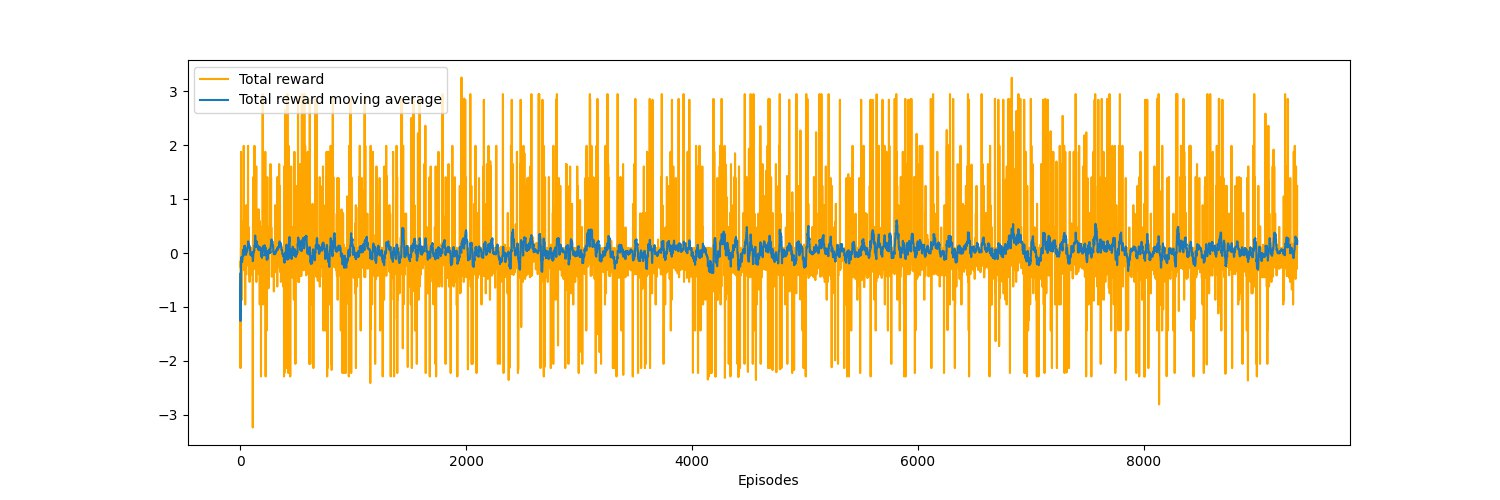

#### 20k episodi

Supponendo che il numero di episodi di training non fosse adeguata affinchè il modello potesse imparare la policy obiettivo, è stato condotto un test con 20.000 episodi con un numero di step massimo di 20 azioni per ogni episodio (gli altri parametri sono stati lasciati alla configurazione di default).

Per poter allenare la DDQN sul cluster del dipartimento, il training è stato suddiviso in sessioni da 2500 episodi ciascuna, salvando i pesi al termine della sessione per poi ricaricarli all'inizio di quella successiva: questo espediente ha permesso di condurre l'allenamento senza che il job Slurm andasse in Out-Of-Memory.



#### Recap delle prestazioni

La tabella seguente riporta i risultati degli esperimenti effettuati: il risultato migliore in termini di metriche misurate è stato ottenuto a seguito del test con 20.000 episodi.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | --- 
**lr 1e-5**    | **9.1822** | **8.7603** | **0.1078**
**lr 1e-4**    | **7.7312** | **9.5924** | **0.1410**
**argmin**     | **16.6831** | **6.0483** | **0.0075**
**env con stessa immagine** | **14.0121** | **6.6658** | **0.0183**
**reward con MSE** | **5.3699** | **11.1078** | **0.1847**
**condizione di terminazione modificata** | **6.2999** | **20.1374** | **0.7912**
**20k episodi** | **1.2215** | **17.2619** | **0.7219**

## Analisi delle prestazioni

Per valutare l'efficacia della soluzione prodotta sono state valutate alcune metriche calcolate sull'immagine prodotta rispetto a quella di riferimento. I valori calcolati sono stati paragonati poi con quelli ottenuti con metodi differenti che affrontano lo stesso problema. 

In aggiunta sono state paragonate le immagini prodotte in output con quelle designate da chi ha costruito il dataset come ground truth. Queste immagini di riferimento sono state prodotte senza l'uso del deep-learning, ma attraverso svariati metodi di image enhancement.


### Analisi qualitativa


L'analisi qualitativa riguarda la valutazione di dati non quantificabili, in questo caso la qualità delle immagini migliorate prodotte dalla DDQN.

Una volta individuata la rete che in seguito all'addestramento ha performato meglio sul validation set, ne è stata testata l'efficacia sulle immagini del test set, un terzo insieme di immagini disgiunto dal training e validation set.

Sono state prese 5 immagini casuali da test set e date in input alla evaluation DQN. La valutazione delle immagini migliorate prodotte ha permesso di valutare qualitativamente le performance.

In [ ]:
#qualitative analysis
TEST_Episodes = 5
ddqn.epsilon = 0 #setting epsilon to 0 to obtain only exploitation
max_test_episode_step = 10 #similar to the value used from the authors of the paper

for e_test in range(TEST_Episodes):
  state = env.reset()
  done = False
  step_count = 1
  while not done:
    action = ddqn.select_action(state) #use eval dqn for predicting optimal action
    new_state,_ = env.step(action) #apply action on the environment image
    done = ddqn.check_if_done(state) #check if image can be improved
    state = new_state #update state with new features
    if done or step_count >= max_test_episode_step: 
      env.render()
      break
    step_count += 1

### Analisi quantitativa

L'analisi quantitativa viene svolta impiegando valori quantificabili per condurre la valutazione. Nello specifico, le metriche usate per condurre l'analisi sono MSE, PSNR e SSIM (già descritte in precedenza).

I valori vengono calcolati in maniera analoga a quanto fatto in fase di validation: 

* viene usata la evaluation DQN per migliorare l'immagine raw fino al raggiungimento della condizione di stop o al raggiungimento del numero di step massimo

* viene calcolato il valore per le tre metriche usando l'immagine ottenuta e quella di riferimento

* si ripetono i primi due punti per ogni immagine del test set e successivamente viene calcolata una media dei valori ottenuti per ogni metrica

* si usano i valori medi ottenuti per paragonare le prestazioni del modello ad altre soluzioni che hanno affrontato lo stesso problema

In [ ]:
#quantitative analysis
ddqn.epsilon = 0 #setting epsilon to 0 to obtain only exploitation
max_test_episode_step = 10 #similar to the value used from the authors of the paper
total_mse = total_psnr = total_ssim = 0 #initialize metrics total counter

for index, (raw_path,ref_path) in enumerate(zip(images_raw_test,images_ref_test)):
  state = env.reset(raw_path, ref_path)
  tot_rewards = 0
  done = False
  step_count = 1
  while not done:
    action = ddqn.select_action(state) #use eval dqn for predicting optimal action
    new_state, reward = env.step(action) #apply action on the environment image
    done = ddqn.check_if_done(state) #check if image can be improved
    tot_rewards += reward #update total reward
    state = new_state #update state with new features
    if done or step_count >= max_test_episode_step: 
      #calculate metrics for the obtained image
      mse = mean_squared_error(np.array(env.current_image), np.array(env.reference_image))
      psnr = peak_signal_noise_ratio(np.array(env.current_image), np.array(env.reference_image))
      ssim = structural_similarity(im1=np.array(env.current_image), im2=np.array(env.reference_image), multichannel=True)
      print("episode: {}/{}, steps: {}, episode reward: {}".format(index, len(images_raw_test), step_count, tot_rewards))
      total_mse += mse
      total_psnr += psnr
      total_ssim += ssim
      break
    step_count += 1

avg_mse = total_mse / len(images_raw_val)
avg_psnr = total_psnr / len(images_raw_val)
avg_ssim = total_ssim / len(images_raw_val)

print("lr: {}, alpha: {}, beta: {}, episode: {} with max steps {}".format(learning_rate,
                                                                          alpha,
                                                                          beta,
                                                                          episodes,
                                                                          episode_max_steps))
print("avg mse: {}, avg_psnr: {}, avg ssim: {}".format(avg_mse,
                                                        avg_psnr,
                                                        avg_ssim))

## Confronto con altre soluzioni

La tabella seguente mostra i risultati ottenuti sul test set di vari modelli proposti dai paper da cui si è preso spunto che trattano il medesimo problema. 

Come valori per il modello implementato in questo paper sono stati scelti quelli ottenuti in fase di testing dal modello che ha presentato le prestazioni migliori in fase di validation.

Method         | MSE(x$10^3$) $\downarrow$ | PSNR $\uparrow$ | SSIM $\uparrow$
---            | ---    | ---     | ---
WaterNet       | 0.7976 | 19.1130 | 0.7971
Water CycleGAN | 1.7298 | 15.7508 | 0.5210
Dense GAN      | 1.2152 | 17.28.43| 0.4426
**DDQN 20k episodi** | **2.1216** | **15.4687** | **0.6281**

Nonostante il modello abbia ottenuto un risultato apprezzabile sul validation set, sul test set le prestazioni risultano poco interessanti. Il modello non riesce a generalizzare (overfitting) e, per quanto il risultato potrebbe dipendere anche dalla dimensione del training set che risulta troppo piccola, è possibile che aumentando il numero di episodi di training il modello raggiunga prestazioni migliori.  

## Team contribution


In questa sezione si è voluto ricapitolare il contributo del team:

* raccolta delle funzioni di Image Enhancement da librerie differenti

* implementazione di un environment che ha come stato una coppia composta da un'immagine di riferimento e da un'immagine raw sulla quale vengono effettuate le azioni

* implementazione di una funzione che calcola valore (reward) che indica la qualità del miglioramento effettuato sull'immagine raw rispetto all'immagine di riferimento, ovvero se l'immagine ottenuta risulta più o meno simile alla ground truth

* implementazione del framework per fare Underwater Image Enhancement, basato sull'utilizzo di una DDQN addestrata su un dataset di immagini sottomarine per imparare la policy ottima per la selezione delle azioni da applicare sull'immagine attuale dell'environment

* training, validation e testing della rete implementata utilizzando diverse configurazioni di iperparametri e valutando quale permette di raggiungere le prestazioni migliori

* comparazione dei risultati ottenuti con quelli di metodi che hanno affrontato lo stesso problema

##Errori/Problematiche

Il Reinforcement Learning richiede lunghe sessioni di training per apprendere ed ha bisogno anche di un'attenta calibrazione degli iperparametri.

Durante lo svolgimento del progetto si è preso spunto dall'articolo dal quale è nata l'idea del progetto, mentre il repository degli autori forniva un'implementazione a tratti discordante da quanto esposto nell'articolo e il reverse engineering totale del codice avrebbe richiesto un'enorme quantità di tempo. Per questi due motivi si è scelto di reimplementare l'architettura del sistema.

Inoltre non si è potuto eseguire il codice del repository, essendoci un modulo mancante. Quindi non si è potuta verificare l'effettiva validità della soluzione.

Alcuni iperparametri non vengono citati nel paper e sono stati quindi scelti autonomamente. Alcuni valori sono stati invece alterati perchè ritenuti poco sensati: ad esempio l'articolo propone di fare il train dell'evaluation e l'update della target dopo ogni step. Ciò significa che i pesi verrebbero aggiornati ad ogni step e non si sfrutterebbe il fatto di avere due modelli diversi perchè avrebbero sempre gli stessi pesi.

I test effettuati sul cluster HPC del DISI hanno fatto supporre l'incapacità del modello di apprendere il comportamento desiderato. L'agente non imparava e, a un certo punto, tendeva a scegliere sempre la stessa azione in exploitation (questo accadeva con qualsiasi scelta di parametri). Si è pensato che questo dipendesse dal numero di episodi di training troppo basso, ma risultava impossibile condurre sessioni più lunghe a causa della memoria disponibile per il job Slurm: in particolare il job in esecuzione sul cluster si interrompe dopo circa 3-4 ore per via di un errore di Out-Of-Memory. Non è stato possibile cambiare la quantità di memoria allocata al job a causa della mancanza dei permessi necessari per eseguire i comandi richiesti.

**La prova condotta salvando i pesi a fine sessione e caricandoli all'inizio del training successivo ha dimostrato che il modello riesce a imparare, ottenendo risultati interessanti, ma sono richiesti un numero ancora maggiore di episodi per ottenere risultati eccellenti.**

## Riferimenti in letteratura



[1] Underwater Image Enhancement With Reinforcement Learning - https://ieeexplore.ieee.org/document/9751218

[2] Chongyi Li, Chunle Guo, Wenqi Ren, Runmin Cong, Junhui Hou, Sam Kwong, Dacheng Tao - 
An Underwater Image Enhancement Benchmark Dataset and Beyond - https://ieeexplore.ieee.org/document/8917818

[3] K. He, J. Sun, and X. Tang, “Single image haze removal using dark
channel prior,” IEEE Trans. Pattern Anal. Mach. Intell., vol. 33, no. 12,
pp. 2341–2353, Dec. 2011. - https://ieeexplore.ieee.org/document/5567108

[4] Van Hasselt, H., Guez, A., & Silver, D. (2016, February). Deep Reinforcement Learning with Double Q-Learning. In AAAI (Vol. 2, p. 5), - https://arxiv.org/pdf/1509.06461.pdf